```
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
IBM Maximo Application Suite
© Copyright IBM Corp. 2019,2020,2021,2022 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
```

Data set: kaggle_pump_reindexed_imputed_v3.csv

## Part 1 - Introduction


The notebooks use a sample dataset to show how data can be ingested, and loaded into the backend systems in Maximo-Predict before a data scientist can proceed to train the models.

This notebook should be run to setup the data in Maximo-Predict before scoring. The following flow chart illustrates the sequence of steps, following which this demo can be adapted for any dataset.

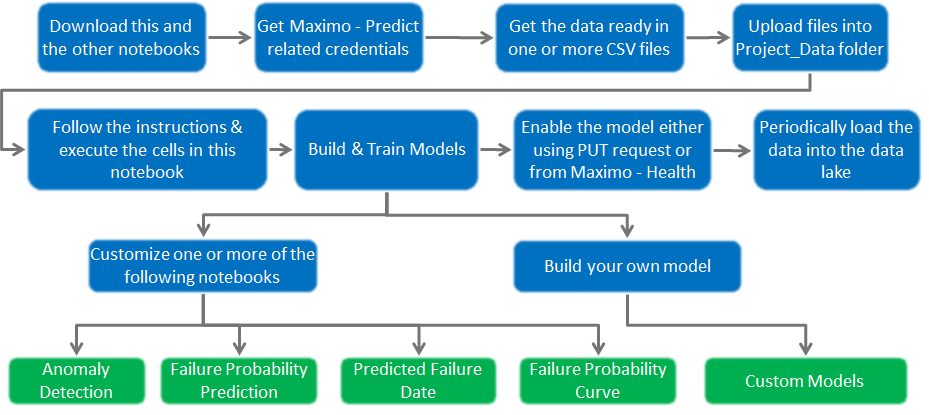

There are 2 notebooks provided including this one. This notebook creates the objects in Maximo-Predict, and loads the essential data into the systems.

This notebook performs a series of operations involving Maximo-Predict as outlined in the following flowchart. Note that it is preferable to delete the objects in the system before recreating them for the demo purposes. The following diagram shows the sequences of delete operations and create operations performed in this notebook. Not following this recommendation could leave corrupt entries behind  causing errors and poor results. 

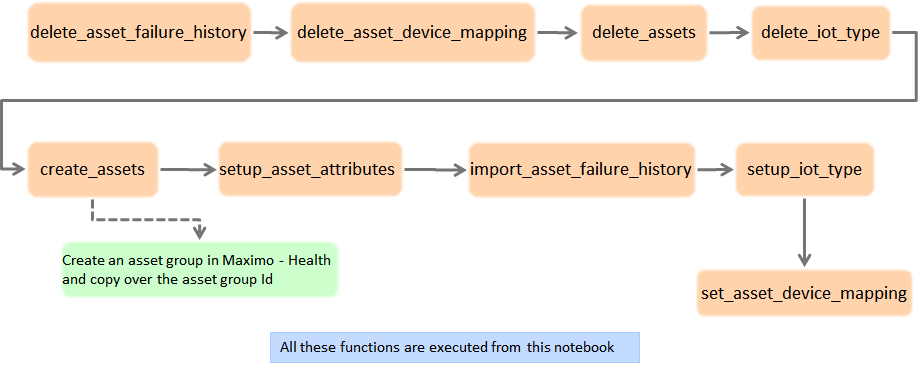

A brief explanation of these operations is as follows

+ **asset_device_mapping**: In reality, assets and their observation (from sensor readings) are usually processed separately. In most cases, asset and sensor data come from and managed by different systems. Maximo-Predict supports getting asset data stored and managed by Maximo, and sensor data from Watson IoT Platform. Assets and sensors are different entities and in order to use both data together, we need to link individual assets and sensors. This is what asset-device mapping is for. Essentially, it indicates for a sensor reading comes in which asset the reading belongs to. An asset can be associated with one or more sensors. On the other hand, a sensor can also be linked to multiple assets, though not common.

+ **Site**: In Maximo, to uniquely identify an asset, you need a site and an asset ID. There are many considerations in planning Maximo organization and site structures, but for our purpose, using assets in Maximo-Predict, we need both site and asset ID in order to identify an asset. If you don't have any site created yet, it's fine to start with site 'BEDFORD' which comes with the sample data set in Maximo.

#### Prerequisites for building the demo

+ Obtain access to Maximo-Predict
+ Get the datasets ready as CSV files (see below)
+ Load all the notebooks into your Watson Studio project

#### Maximo-Predict requires following csv files (dataframes). If your csv files are not in the same format you will need to convert them. We will show you an example in this notebook. 

As you can see in the following formats, there are things that come from your dataset. For example, things like `asset_id` (12 char or less), which is the id of the asset being analyzed, monitored, and studied. However things like `site`, and `devicetype` are the ones you configure in Maximo and IoT platform before embarking on this exercise. 

Except where stated explicitly, the names of the columns are up to the user's choice. It is a matter of preference whether you call it `asset_id` or `equipment_id`. However if your dataset involves a column name different from the one shown here in the example, you need to change the pandas function accordingly in one or more cells below. If you would rather avoid that exercise, then prepare your data using the following structure including the column names to the extent possible. 

Likewise the variable names are also changeable. Instead of calling your IoT object `devicetype`, you can choose to call it `iot_device_type`, so that you can use the word `devicetype` (or `device_type`) for something in your dataset. But if you choose to change any of the variables declared here, then it is important you modify the place(s) where the variables are used.

It should be noted that the column names could be case sensitive in various systems, and certainly so in Pandas. Therefore it is safer to use a consistent case across your variables and other names.

+ Combined Asset and Asset Attribute csv file (dataframe) format -

| asset_id | installation_timestamp | site |
| ----- | ----- | ---- |  
| LOBA20 | 2017-01-19 05:46:29 | BEDFORD|  

+ Asset failure history csv file (dataframe) format -

| asset_id | timestamp | site | deviceid |
|------------| ------- | ------------ | ------ |
| LOBA20 |  2017-01-19 23:29:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-07 00:18:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-08 09:20:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-09 09:06:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-17 13:41:00 | BEDFORD | LOBSensor20191004_1 |

+ IOT sensor csv file (dataframe) format -


| asset_id | timestamp | var1 | var2| var3 | ...... | var_n| deviceid | devicetype |
|------------| ------- | ------------ | ------ | -------|-------|--------|------------|----------------|
| LOBA20 |  2017-01-19 23:29:00 | 34.35 | 65.86 |467.39| ....| 464.73|LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  2017-01-21 17:38:48 | 47.48 | 38.59 | 483.49| ....|463.59|LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  2017-01-19 21:59:37 | 36.67 | 37.76 | 294.65| ....|120.57|LOBSensor20191004_1 | LOBSensor20191004 |


+ Asset-Device mapping csv file (dataframe) format - 

| asset_id | site   | deviceid | devicetype|
|------------| ------- | ------------ | ------ |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |

## Install the Maximo Predict SDK

You will need follow 4 credentials to run the notebook. You can obtain first 3 credentials if you are admin on Maximo Predict UI. Otherwise, you will have to get these from your admin.

You will only have to follow these steps for the first notebook. So, if you have already created the `Predict_Envs.json` file, you can skip ahead to running this notebook.

Steps

- APM_ID: Application Administration -> System Properties -> Filter -> Search PMIId -> Current Value
- APM_API_BASEURL: Application Administration -> Integration -> End Points--> Searh for predict -> click search result PREDICTAPI -> URL (note you just need first part of the url)
- APM_API_KEY: Application Administration -> Go To Administration -> Copy key from user card, or Add API key for the user if API key does not exist.

Step to get db2_certificate.pem:

- Login CP4D. Click Services->Instances. Click the Predict DB. Click "Download SSL Certificate" and save it to the file named as db2_certificate.pem. Then upload the db2_certificate.pem to the CP4D by click "New data Asset".

These can then be placed in a file called `Predict_Envs.json`, formatted like this:

```json
{
  "APM_ID": "*******",
  "APM_API_BASEURL": "https://*********",
  "APM_API_KEY": "**************************",
  "USER_PROVIDED_HEALTH_URL": "",
  "USER_PROVIDED_DB_CONNECTION_STRING": "",
  "USER_PROVIDED_URL": ""
}
```

The three `USER_PROVIDED_*` fields are only necessary if connecting to a deployment not in this CP4D environment.

After creating the JSON file, add it as a data asset to the current project in CP4D.

The code below pulls the credentials from that JSON file and sets them as environment variables in this runtime.


In [4]:
import json
import os

# Opening JSON file
f = open('/project_data/data_asset/Predict_Envs.json',)
data = json.load(f)
f.close()

os.environ['APM_ID'] = data['APM_ID']
os.environ['APM_API_BASEURL'] = data['APM_API_BASEURL']
os.environ['APM_API_KEY'] = data['APM_API_KEY']

# README: Change to true if Health/Predict are deployed on different cluster from this CP4D environment
use_external = False
if use_external:
    import os
    os.environ['USER_PROVIDED_HEALTH_URL'] = data['USER_PROVIDED_HEALTH_URL']
    os.environ['USER_PROVIDED_DB_CONNECTION_STRING'] = data['USER_PROVIDED_DB_CONNECTION_STRING']
    os.environ['USER_PROVIDED_URL'] = data['USER_PROVIDED_URL']

In [5]:
import os

os.environ['SSL_VERIFY_APM'] = 'False'
os.environ['SSL_VERIFY_AS'] = 'False'

os.environ['TRUST_PREDICT'] = os.getenv('APM_API_BASEURL')[8:]
print(os.getenv('TRUST_PREDICT'))

maslab-predict-api.mas-maslab-predict.svc


In [6]:
import os
os.environ['TRUST_PREDICT'] = os.getenv('APM_API_BASEURL')[8:]
print(os.getenv('TRUST_PREDICT'))

maslab-predict-api.mas-maslab-predict.svc


Finally, install pmlib with `pip`:

In [7]:
!pip install --trusted-host ${TRUST_PREDICT} ${APM_API_BASEURL}/ibm/pmi/service/rest/ds/${APM_ID}/${APM_API_KEY}/lib/download?filename=pmlib

     |████████████████████████████████| 189.3 MB 59.7 MB/s eta 0:00:01    |████████████████▋               | 98.6 MB 37.7 MB/s eta 0:00:03     |█████████████████               | 101.0 MB 37.7 MB/s eta 0:00:03     |█████████████████████▊          | 128.3 MB 37.7 MB/s eta 0:00:02.5 MB/s eta 0:00:06
Processing //tmp/1000710000/pip-req-build-5z4ftecn/dslib/srom-1.4.0rc7.1.0-cp38-cp38-linux_x86_64.whl
Processing //tmp/1000710000/pip-req-build-5z4ftecn/dslib/dqlearn-0.4.2.1.0-cp38-cp38-linux_x86_64.whl
Processing //tmp/1000710000/pip-req-build-5z4ftecn/dslib/aixclient.zip
dqlearn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
srom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
  Created wheel for aixclient: filename=aixclient-1.2.2-py3-none-any.whl size=5088 sha256=a9211b097025dc0f50d262420671d0c4f8a427c4590828c7dc51a3f788d4a88c
  Sto

In [8]:

!pip install pyspark=='3.0.1'

In [1]:
!pip install git+https://github.com/sedgewickmm18/mmfunctions.git

  Cloning https://github.com/sedgewickmm18/mmfunctions.git to /tmp/1000710000/pip-req-build-f4_o4n09
  Running command git clone -q https://github.com/sedgewickmm18/mmfunctions.git /tmp/1000710000/pip-req-build-f4_o4n09
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 1.1 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 8.0 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 32.7 MB/s eta 0:00:01
  Created wheel for mmfunctions: filename=mmfunctions-0.0.5-py3-none-any.whl size=87177 sha256=a928373fd7a1aa59a13c79904041fc3cb2696c27b3e27ad0115ea93dc9aa0748
  Stored in directory: /tmp/1000710000/pip-ephem-wheel-cache-fodpsntl/wheels/1f/ce/b9/55ef08bcadde00d78dbafdf51078cc9c669d29266694e3ef3e
Successfully built mmfunctions
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.35.0
    Uninstalling grpcio-1.35.0:
      Successfully uninstalled grpcio-1.35.0
  Attempting uninstall: opt-ei

In [ ]:
import logging
logging.getLogger('pyspark').setLevel(logging.ERROR)
logging.getLogger('py4j').setLevel(logging.ERROR)
logging.getLogger('py4j.java_gateway').setLevel(logging.ERROR)

#### Import pmlib

In [9]:
# Initialize the Maximo-Predict environment variables

import pmlib
from pmlib import api
api.init_environ()

2022-07-15T21:19:10.636 tensorflow.<module> DEBUG Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2022-07-15T21:19:11.524 pmlib.api.init_environ INFO APM_ID=7e6fac8a, APM_API_BASEURL=https://maslab-predict-api.mas-maslab-predict.svc, APM_API_KEY=********
2022-07-15T21:19:11.526 pmlib.util.api_request INFO method=get, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/ds/tenant?instanceId=7e6fac8a, headers={'apmapitoken': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-15T21:19:11.713 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/ds/tenant?instanceId=7e6fac8a
2022-07-15T21:19:11.715 pmlib.api.init_environ DEBUG resp={
    "as_apikey": "********",
    "as_apitoken": "********",
    "as_id": null,
    "as_url": "https://skolab.api.monitor.mas8lab.gtm-pat.com",

('7e6fac8a',
 'https://maslab-predict-api.mas-maslab-predict.svc',
 'at73dm4144gf1aaa4ho1236srr2ut7v74ik6vrf7')

In [10]:
import pandas as pd
import numpy as np
import requests

import json
import os
import time
from datetime import datetime
from datetime import timedelta
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simple_filter = simplefilter(action='once', category=UserWarning)

#### Define some initial values

You will define your own device_type, site_id, asset_prefix and install_date for your training dataset.

Please mark down device_type used here. You will need it in future notebooks

In [11]:
newAssetPrefix = 'PREDICTPUMP'
oem_prefix = 'OEMGRP'
afm_prefix = 'AFMGRP'
default_device_type = 'PREDICT_PUMP'
default_site_id = 'BEDFORD'


device_ids_oem = ['HC_PMPDEVICE00']
print(device_ids_oem)

device_ids_afm = [newAssetPrefix+'DEVICE00'+str(n) for n in range(1, 10, 2)]
print(device_ids_afm)

asset_group_label_oem = newAssetPrefix + oem_prefix
asset_group_label_afm = newAssetPrefix + afm_prefix

print('asset_group_label_oem = '+asset_group_label_oem)
print('asset_group_label_afm = '+asset_group_label_afm)


device_type_oem = default_device_type
device_type_afm = default_device_type

['HC_PMPDEVICE00']
['PREDICTPUMPDEVICE001', 'PREDICTPUMPDEVICE003', 'PREDICTPUMPDEVICE005', 'PREDICTPUMPDEVICE007', 'PREDICTPUMPDEVICE009']
asset_group_label_oem = PREDICTPUMPOEMGRP
asset_group_label_afm = PREDICTPUMPAFMGRP


In [55]:
store[notebook_name]["outputs"]["device_type"] = default_device_type

In [14]:
# define column name variables so they are consistent
install_date_col_name = 'installdate'
timestamp_col_name = 'evt_timestamp'
site_id_col_name = 'site_id'

fail_date_col_name = 'fail_date'
decommission_date_col_name = 'decommission_date'
asset_id_col_name = 'asset_id'
device_type_col_name = 'devicetype'
device_id_col_name = 'deviceid'
asset_id=newAssetPrefix+'_3456'

## Part 3 - Load the Data Into Dataframes

We will load three separate CSV files containing basic metadata about the devices, sensor readings from the devices, and failure information from the devices.

In [15]:
# load install and decommission dates for assets
asset_installation_decommission_dates_df = pd.read_csv('/project_data/data_asset/hc_asset_attributes.csv')

asset_installation_decommission_dates_df['installdate'] = pd.to_datetime(asset_installation_decommission_dates_df['installdate'])
asset_installation_decommission_dates_df.rename(columns={'installdate': install_date_col_name}, inplace=True)

asset_installation_decommission_dates_df['decommission_date'] = pd.to_datetime(asset_installation_decommission_dates_df['decommission_date'])
print(asset_installation_decommission_dates_df.shape)
asset_installation_decommission_dates_df.replace(to_replace=r'^PMP*', value=newAssetPrefix, regex=True, inplace=True)

#set asset_id to be AIPUMP_3456
asset_installation_decommission_dates_df[asset_id_col_name]=asset_id
asset_installation_decommission_dates_df.head(10)

(1, 3)


asset_id installdate decommission_date
0  PREDICTPUMP_3456  2008-01-08               NaT

In [17]:
# load sensor data for assets
sensor_data_afm_df = pd.read_csv('/project_data/data_asset/kaggle_pump_reindexed_imputed_v3.csv')
sensor_data_afm_df['devicetype'] = device_type_afm
sensor_data_afm_df[asset_id_col_name] = asset_id
print(sensor_data_afm_df.shape)
sensor_data_afm_df.head()

(930, 56)


asset_id   timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
0  PREDICTPUMP_3456  2019-12-24   2.454124  48.521651  53.086659  45.917967   
1  PREDICTPUMP_3456  2019-12-25   2.454091  48.067611  52.885319  45.239437   
2  PREDICTPUMP_3456  2019-12-26   2.454162  46.882473  52.547741  44.823735   
3  PREDICTPUMP_3456  2019-12-27   2.454222  46.601319  52.434171  45.273677   
4  PREDICTPUMP_3456  2019-12-28   2.453987  47.860242  52.780427  46.145350   

    sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_45  sensor_46  \
0  634.261195  75.106401  13.517834  16.159856  ...  49.429334  46.482768   
1  634.028005  72.457242  13.597486  16.157967  ...  61.837706  51.240998   
2  633.935177  74.061776  13.513292  16.160580  ...  55.592528  42.742091   
3  634.954348  73.439419  13.344946  16.167010  ...  50.724987  44.700038   
4  634.696986  75.166017  13.351055  16.161303  ...  52.858153  48.866705   

   sensor_47   sensor_48   sensor_49   sensor_50   sensor_51  machine_status  \
0  39.031957  183.920076   75.800541  231.928371  207.921807          NORMAL   
1  38.736175  200.657471  103.338798  245.225696  216.391781          NORMAL   
2  39.072144  214.248972  108.018260  241.538062  210.863552          NORMAL   
3  42.306456  200.869662   96.164481  242.978392  212.594844          NORMAL   
4  42.751736  202.019033  101.538388  231.573112  220.992476          NORMAL   

   target_label    devicetype  
0             0  PREDICT_PUMP  
1             0  PREDICT_PUMP  
2             0  PREDICT_PUMP  
3             0  PREDICT_PUMP  
4             0  PREDICT_PUMP  

[5 rows x 56 columns]

In [18]:
sensor_data_afm_df.tail(10)

asset_id   timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
920  PREDICTPUMP_3456  2022-07-01   2.522732  44.343653  51.991945  43.985820   
921  PREDICTPUMP_3456  2022-07-02   2.522710  44.733552  51.951677  44.716192   
922  PREDICTPUMP_3456  2022-07-03   2.496739  44.747296  52.038241  44.462528   
923  PREDICTPUMP_3456  2022-07-04   2.489284  45.122250  52.205825  44.457223   
924  PREDICTPUMP_3456  2022-07-05   2.318808  45.833332  52.994790  43.880210   
925  PREDICTPUMP_3456  2022-07-06   0.172472  46.828883  51.291231  46.587456   
926  PREDICTPUMP_3456  2022-07-07   0.614321  48.530573  49.613954  45.200856   
927  PREDICTPUMP_3456  2022-07-08   1.481401  51.983746  48.135608  43.817514   
928  PREDICTPUMP_3456  2022-07-09   2.434437  51.995079  48.863328  43.462576   
929  PREDICTPUMP_3456  2022-07-10   2.500832  51.597702  50.573638  43.413144   

      sensor_04  sensor_05  sensor_06  sensor_07  ...   sensor_45  sensor_46  \
920  637.408046  69.444939  14.609977  16.673139  ...   46.185378  60.170717   
921  636.484204  67.574572  14.614518  16.673902  ...   41.107253  48.148148   
922  627.261035  69.828448  14.586467  16.615710  ...   39.462770  42.420589   
923  614.577537  71.864315  14.453205  16.162870  ...   39.277906  47.312243   
924  420.503448  72.520400  14.185470  16.247110  ...   52.662040  67.129630   
925   72.795133  32.429265  15.117729  17.664026  ...  103.461379  68.992333   
926  221.001779  56.179151  12.409536  13.985703  ...   39.850180  48.839376   
927  479.472308  71.571084  13.227680  14.944983  ...   68.042696  80.476786   
928  633.201125  74.302791  14.625570  16.663333  ...   39.634773  47.466667   
929  637.063682  72.089349  14.628543  16.664780  ...   40.473894  47.694831   

     sensor_47   sensor_48   sensor_49  sensor_50   sensor_51  machine_status  \
920  54.867541  190.144354   60.680298     1000.0  209.410369          NORMAL   
921  66.668274  198.750962   78.460970     1000.0  253.925540          NORMAL   
922  48.598251  128.081596   60.450424     1000.0  206.092463          NORMAL   
923  41.589506  145.632397   53.891782     1000.0  180.171362          NORMAL   
924  43.981480  230.324100   69.733800     1000.0  205.729200          BROKEN   
925  67.961516  371.509694  340.567138     1000.0  277.361831      RECOVERING   
926  42.145705   56.196953   37.863296     1000.0   43.594072          NORMAL   
927  64.388822   94.325592   76.893647     1000.0   73.849023          NORMAL   
928  45.698302  118.840020   47.898984     1000.0  108.949009          NORMAL   
929  44.286908  125.564235   47.738234     1000.0  169.577873          NORMAL   

     target_label    devicetype  
920             0  PREDICT_PUMP  
921             0  PREDICT_PUMP  
922             0  PREDICT_PUMP  
923             0  PREDICT_PUMP  
924             1  PREDICT_PUMP  
925             1  PREDICT_PUMP  
926             0  PREDICT_PUMP  
927             0  PREDICT_PUMP  
928             0  PREDICT_PUMP  
929             0  PREDICT_PUMP  

[10 rows x 56 columns]

In [19]:
# update the device IDs with your specified new asset prefix
sensor_data_afm_df.replace(to_replace=r'^PMP*', value=newAssetPrefix, regex=True, inplace=True)
sensor_data_afm_df.head()

# convert timestamp column to a datetime
timestamp_col_csv = 'timestamp'
sensor_data_afm_df[timestamp_col_csv] = pd.to_datetime(sensor_data_afm_df[timestamp_col_csv])

# rename column because Maximo uses the name 'evt_timestamp'
sensor_data_afm_df = sensor_data_afm_df.rename(columns={timestamp_col_csv: timestamp_col_name})

sensor_data_afm_df.head()


asset_id evt_timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
0  PREDICTPUMP_3456    2019-12-24   2.454124  48.521651  53.086659  45.917967   
1  PREDICTPUMP_3456    2019-12-25   2.454091  48.067611  52.885319  45.239437   
2  PREDICTPUMP_3456    2019-12-26   2.454162  46.882473  52.547741  44.823735   
3  PREDICTPUMP_3456    2019-12-27   2.454222  46.601319  52.434171  45.273677   
4  PREDICTPUMP_3456    2019-12-28   2.453987  47.860242  52.780427  46.145350   

    sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_45  sensor_46  \
0  634.261195  75.106401  13.517834  16.159856  ...  49.429334  46.482768   
1  634.028005  72.457242  13.597486  16.157967  ...  61.837706  51.240998   
2  633.935177  74.061776  13.513292  16.160580  ...  55.592528  42.742091   
3  634.954348  73.439419  13.344946  16.167010  ...  50.724987  44.700038   
4  634.696986  75.166017  13.351055  16.161303  ...  52.858153  48.866705   

   sensor_47   sensor_48   sensor_49   sensor_50   sensor_51  machine_status  \
0  39.031957  183.920076   75.800541  231.928371  207.921807          NORMAL   
1  38.736175  200.657471  103.338798  245.225696  216.391781          NORMAL   
2  39.072144  214.248972  108.018260  241.538062  210.863552          NORMAL   
3  42.306456  200.869662   96.164481  242.978392  212.594844          NORMAL   
4  42.751736  202.019033  101.538388  231.573112  220.992476          NORMAL   

   target_label    devicetype  
0             0  PREDICT_PUMP  
1             0  PREDICT_PUMP  
2             0  PREDICT_PUMP  
3             0  PREDICT_PUMP  
4             0  PREDICT_PUMP  

[5 rows x 56 columns]

In [20]:

df1=sensor_data_afm_df[sensor_data_afm_df['machine_status'] == 'BROKEN'].head(15)
df2=df1[['asset_id','evt_timestamp']]
df2

asset_id evt_timestamp
95   PREDICTPUMP_3456    2020-03-28
136  PREDICTPUMP_3456    2020-05-08
385  PREDICTPUMP_3456    2021-01-12
432  PREDICTPUMP_3456    2021-02-28
711  PREDICTPUMP_3456    2021-12-04
784  PREDICTPUMP_3456    2022-02-15
924  PREDICTPUMP_3456    2022-07-05

In [21]:
df2[site_id_col_name]='BEDFORD'
df2[device_id_col_name]='PREDICTPUMP001'
failure_data_afm_df=df2.rename(columns={'evt_timestamp':'fail_date'})
failure_data_afm_df['fail_date'] = pd.to_datetime(failure_data_afm_df['fail_date'])
failure_data_afm_df

asset_id  fail_date  site_id        deviceid
95   PREDICTPUMP_3456 2020-03-28  BEDFORD  PREDICTPUMP001
136  PREDICTPUMP_3456 2020-05-08  BEDFORD  PREDICTPUMP001
385  PREDICTPUMP_3456 2021-01-12  BEDFORD  PREDICTPUMP001
432  PREDICTPUMP_3456 2021-02-28  BEDFORD  PREDICTPUMP001
711  PREDICTPUMP_3456 2021-12-04  BEDFORD  PREDICTPUMP001
784  PREDICTPUMP_3456 2022-02-15  BEDFORD  PREDICTPUMP001
924  PREDICTPUMP_3456 2022-07-05  BEDFORD  PREDICTPUMP001

#### Change Sensor DataFrame

## Part 5 - Clean up DataFrames

This section creates and changes the dataframes so they work when we add them to Maximo.

In [22]:
asset_all_df = asset_installation_decommission_dates_df

# add devicetype column to DF; map each device to it's proper device type- either AFM or OEM
asset_all_df[device_type_col_name] = asset_all_df[asset_id_col_name].map(
    lambda x: device_type_oem if x in list(sensor_data_afm_df[asset_id_col_name].unique()) else device_type_afm)

asset_all_df[device_id_col_name] = asset_all_df[asset_id_col_name]

asset_all_df[site_id_col_name] = default_site_id
asset_all_df.head()


asset_id installdate decommission_date    devicetype  \
0  PREDICTPUMP_3456  2008-01-08               NaT  PREDICT_PUMP   

           deviceid  site_id  
0  PREDICTPUMP_3456  BEDFORD

Construct asset device mapping- Maximo will use these to determine which asset group your devices below to.

In [23]:
asset_device_mapping_df = asset_all_df.drop([install_date_col_name, decommission_date_col_name], axis=1)
asset_device_mapping_df.head()


asset_id    devicetype          deviceid  site_id
0  PREDICTPUMP_3456  PREDICT_PUMP  PREDICTPUMP_3456  BEDFORD

## Part 6 - Delete existing data

In the next few cells the objects in Maximo-Predict data lake are going to be deleted. This is to make sure you can recreate this flow as many times as necessary (or if something goes wrong in the first attempt).

Note that we delete all the events here including both training and testing segments. This is being done in order to minimize calls across the wire to the underlying system (Maximo). This is fine as long as the dataset is small in size, for large datasets this will unnecessarily increase the memory footprint. In that case you may be better off not combining things into one dataset.

In [24]:
failure_data_afm_df.rename(columns={'site': site_id_col_name}, inplace=True)
failure_data_afm_df.head()

asset_id  fail_date  site_id        deviceid
95   PREDICTPUMP_3456 2020-03-28  BEDFORD  PREDICTPUMP001
136  PREDICTPUMP_3456 2020-05-08  BEDFORD  PREDICTPUMP001
385  PREDICTPUMP_3456 2021-01-12  BEDFORD  PREDICTPUMP001
432  PREDICTPUMP_3456 2021-02-28  BEDFORD  PREDICTPUMP001
711  PREDICTPUMP_3456 2021-12-04  BEDFORD  PREDICTPUMP001

In [25]:
resp = pmlib.delete_asset_failure_history(failure_data_afm_df, siteid_column=site_id_col_name, assetid_column=asset_id_col_name)
print(resp)

2022-07-15T21:23:53.002 pmlib.api._maximo_bulk_delete DEBUG resource_query=oslc.where=assetnum in ["PREDICTPUMP_3456"] and wonum="APM%25" and siteid="BEDFORD"
2022-07-15T21:23:53.004 pmlib.util.api_request INFO method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiwodetail?lean=1&oslc.where=assetnum in ["PREDICTPUMP_3456"] and wonum="APM%25" and siteid="BEDFORD", headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-15T21:23:53.120 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiwodetail?lean=1&oslc.where=assetnum in ["PREDICTPUMP_3456"] and wonum="APM%25" and siteid="BEDFORD"
2022-07-15T21:23:53.122 pmlib.util.api_request INFO method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiwodetail?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[], session=

In [26]:
# delete asset_device mapping for training
pmlib.delete_asset_device_mappings(df=asset_device_mapping_df, siteid_column=site_id_col_name, assetid_column=asset_id_col_name)

2022-07-15T21:23:55.861 pmlib.api._get_db INFO db2
2022-07-15T21:23:55.862 pmlib.api._get_db INFO db2
2022-07-15T21:23:55.864 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-iot-db2u-engn-svc.db2u.svc;PORT=50001;PROTOCOL=TCPIP;UID=db2inst1;PWD=DkJ1KUNjxKsjXi8;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-15T21:23:56.864 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-15T21:23:56.866 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-15T21:23:56.867 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-15T21:23:56.867 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: db2
2022-07-15T21:23:56.868 iotfunctions.db.__init__ DEBUG Found certificate filename in os variable DB_CERTIFICATE_FILE: /project_data/data_asset/db2_certif

In [27]:
asset_all_df

asset_id installdate decommission_date    devicetype  \
0  PREDICTPUMP_3456  2008-01-08               NaT  PREDICT_PUMP   

           deviceid  site_id  
0  PREDICTPUMP_3456  BEDFORD

In [28]:
# delete training asset
resp = pmlib.delete_assets(asset_all_df, siteid_column=site_id_col_name, assetid_column=asset_id_col_name)
print(resp)

2022-07-15T21:24:16.580 pmlib.api._maximo_bulk_delete DEBUG resource_query=oslc.where=assetnum in ["PREDICTPUMP_3456"] and siteid="BEDFORD"
2022-07-15T21:24:16.582 pmlib.util.api_request INFO method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?lean=1&oslc.where=assetnum in ["PREDICTPUMP_3456"] and siteid="BEDFORD", headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-15T21:24:16.684 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?lean=1&oslc.where=assetnum in ["PREDICTPUMP_3456"] and siteid="BEDFORD"
2022-07-15T21:24:16.686 pmlib.util.api_request INFO method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[], session=None, kwargs={}
2022-07-15T21:24:16.799 pmlib.util.api_request INF

In [29]:
device_type_afm

'PREDICT_PUMP'

In [30]:
# delete sensor data from data lake for training
pmlib.delete_iot_type(name=device_type_afm)
time.sleep(300)  # wait 5 minute for AS to finish the job.

2022-07-15T21:24:31.315 pmlib.api._call_wiotp INFO https://skolab.iot.mas8lab.gtm-pat.com
2022-07-15T21:24:31.318 pmlib.util.api_request INFO method=get, url=https://skolab.iot.mas8lab.gtm-pat.com/api/v0002/device/types/PREDICT_PUMP/devices, headers={}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={'auth': ('a-skolab-kkv6vx60sv', 'mn)Jmpp+Qs2IW7O7)f')}
2022-07-15T21:24:31.473 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://skolab.iot.mas8lab.gtm-pat.com/api/v0002/device/types/PREDICT_PUMP/devices
2022-07-15T21:24:31.475 pmlib.api._call_wiotp INFO https://skolab.iot.mas8lab.gtm-pat.com
2022-07-15T21:24:31.476 pmlib.util.api_request INFO method=post, url=https://skolab.iot.mas8lab.gtm-pat.com/api/v0002/bulk/devices/remove, headers={}, timeout=300, ssl_verify=False, json=[], session=None, kwargs={'auth': ('a-skolab-kkv6vx60sv', 'mn)Jmpp+Qs2IW7O7)f')}
2022-07-15T21:24:31.555 pmlib.util.api_request INFO resp.status_code=400, method=post, url=https

KeyboardInterrupt: 

**Note:** Need to wait for 5 minutes before insert

Then, we can create and run some utility functions to delete the old asset group.

In [31]:
from pmlib.api import _call_maximo

# clean up filter and assetgroup
def get_asset_group_href(grouplabel):
    if grouplabel is None:
        raise ValueError('the given argument grouplabel is None')
    resp = _call_maximo(url_path='/os/MXAPIEXPGROUP?lean=1&addid=1&oslc.where=grouplabel=%22'+grouplabel+'%22&oslc.select=*', method='get')
    if resp is not None:
        data = resp.json()
        print(data)
        if len(data['member']) != 0:
            return (data['member'][0]['href'])
    return 0
def delete_asset_group(grouplabel):
    if grouplabel is None:
        raise ValueError('the given argument grouplabel is None')
    href = get_asset_group_href(grouplabel)
    if href != 0 :
        url_path=href.split("/api")[1]
        print(url_path)
        resp = _call_maximo(url_path=url_path, method='delete')
        print(resp)

In [32]:
asset_group_id = pmlib.api.get_maximo_asset_group_id(asset_group_label_afm)
print(asset_group_id)
if asset_group_id is not None:
    url = os.environ.get('APM_API_BASEURL', None) + '/ibm/pmi/service/rest/assetgroup/' + asset_group_id + '?instanceId=' +os.environ.get('APM_ID', None)
    header={
        'apmapitoken':os.environ.get('APM_API_KEY', None)
    }
    response = requests.delete(url, headers=header,verify=False)
    print(response)

delete_asset_group(asset_group_label_afm)

2022-07-15T21:24:41.542 pmlib.util.api_request INFO method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiexpgroup?oslc.select=expgroupname&lean=1&querylocalized=1&oslc.where=grouplabel="PREDICTPUMPAFMGRP", headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-15T21:24:41.638 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiexpgroup?oslc.select=expgroupname&lean=1&querylocalized=1&oslc.where=grouplabel="PREDICTPUMPAFMGRP"
None
2022-07-15T21:24:41.640 pmlib.util.api_request INFO method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/MXAPIEXPGROUP?lean=1&addid=1&oslc.where=grouplabel=%22PREDICTPUMPAFMGRP%22&oslc.select=*, headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-15T21:24:41.726 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://

## Part 7 - Insert data

Note that this example loads the data into the underlying systems as follows:
+ As for Measurement data, the testing segment is loaded in the data lake as example, but you can choose to load both training and testing segments qualified by different device_type and asset_prefixes . The pattern illustrated here is assuming the training is done using CSV files, and the scoring happens on the data in the data lake & Maximo on an ongoing basis. 
+ The training part of the measurement data is set aside for the training to be done in a separate notebook provided in this package (refer to the notebook titled `DTE_Failure_Probability_Estimation_Training`). 
+ As for the failure data, the entire data is loaded. 

**Now we will start creating the asset objects sensor objects**

Normally, we would manage assets from Maximo. But Maximo-Predict SDK also supports bulk loading assets into Maximo directly from within notebook. This could be useful to load some sample non-existent asset data from CSV files.

1. Invoke the PMLIB API to create the asset in Maximo for training using this dataframe:

In [33]:
asset_all_df.head()

asset_id installdate decommission_date    devicetype  \
0  PREDICTPUMP_3456  2008-01-08               NaT  PREDICT_PUMP   

           deviceid  site_id  
0  PREDICTPUMP_3456  BEDFORD

In [34]:
resp = pmlib.create_assets(asset_all_df, assetid_column=asset_id_col_name, siteid_column=site_id_col_name)

2022-07-15T21:24:51.982 pmlib.util.api_request INFO method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[{'_data': {'assetnum': 'PREDICTPUMP_3456', 'siteid': 'BEDFORD', 'description': 'PREDICTPUMP_3456'}}], session=None, kwargs={}
2022-07-15T21:24:52.163 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?lean=1
2022-07-15T21:24:52.165 pmlib.api._maximo_bulk_create INFO resp_create=[{"_responsemeta":{"status":"201","Location":"http:\/\/localhost\/maxrest\/api\/os\/mxapiasset\/_UFJFRElDVFBVTVBfMzQ1Ni9CRURGT1JE"}}]


2. Create assets for testing using this dataframe:

In [35]:
resp = pmlib.setup_asset_attributes(asset_all_df, assetid_column=asset_id_col_name, siteid_column=site_id_col_name,
                                    attribute_columns=[install_date_col_name], parse_dates=[install_date_col_name])
print(resp)

2022-07-15T21:25:05.253 pmlib.util.api_request INFO method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[{'_data': {'installdate': '2008-01-08T00:00:00', 'assetnum': 'PREDICTPUMP_3456', 'siteid': 'BEDFORD', 'description': 'PREDICTPUMP_3456'}}], session=None, kwargs={}
2022-07-15T21:25:05.372 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?lean=1
2022-07-15T21:25:05.374 pmlib.api._maximo_bulk_create INFO resp_create=[{"_responsedata":{"Error":{"errorattrname":"assetnum","extendedError":{"moreInfo":{"href":"http:\/\/localhost\/maxrest\/api\/error\/messages\/BMXAA4129E"}},"errorobjpath":"asset","correlationid":null,"errattrvalue":null,"reasonCode":"BMXAA4129E","message":"BMXAA4129E - The record for Site=BEDFORD, Asset=PREDICTPUMP_3456 already exists. Ensure that the

3. Create failure history for training using this dataframe:

In [36]:
failure_data_afm_df.head(10)

asset_id  fail_date  site_id        deviceid
95   PREDICTPUMP_3456 2020-03-28  BEDFORD  PREDICTPUMP001
136  PREDICTPUMP_3456 2020-05-08  BEDFORD  PREDICTPUMP001
385  PREDICTPUMP_3456 2021-01-12  BEDFORD  PREDICTPUMP001
432  PREDICTPUMP_3456 2021-02-28  BEDFORD  PREDICTPUMP001
711  PREDICTPUMP_3456 2021-12-04  BEDFORD  PREDICTPUMP001
784  PREDICTPUMP_3456 2022-02-15  BEDFORD  PREDICTPUMP001
924  PREDICTPUMP_3456 2022-07-05  BEDFORD  PREDICTPUMP001

In [37]:
# default_failurecode is the CLASS in the MAXIMO MANAGE
# default_problemcode is the PROBLEMCODE is in the MAXIMO MANAGE
# the Precondition is that default_failurecode and default_problemcode have been set up in MAXIMO MANAGE
resp = pmlib.import_asset_failure_history(failure_data_afm_df, assetid_column='asset_id', siteid_column='site_id',
                                          faildate_column='fail_date', default_failurecode='PUMPS', default_problemcode='STOPPED', wonum_prefix='apm')
print(resp)

2022-07-15T21:25:11.976 numexpr.utils._init_num_threads INFO Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-07-15T21:25:11.981 pmlib.util.api_request INFO method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiwodetail?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[{'_data': {'faildate': '2020-03-28T00:00:00+00:00', 'failurecode': 'PUMPS', 'problemcode': 'STOPPED', 'assetnum': 'PREDICTPUMP_3456', 'siteid': 'BEDFORD', 'wonum': 'APM7155627'}}, {'_data': {'faildate': '2020-05-08T00:00:00+00:00', 'failurecode': 'PUMPS', 'problemcode': 'STOPPED', 'assetnum': 'PREDICTPUMP_3456', 'siteid': 'BEDFORD', 'wonum': 'APM4301648'}}, {'_data': {'faildate': '2021-01-12T00:00:00+00:00', 'failurecode': 'PUMPS', 'problemcode': 'STOPPED', 'assetnum': 'PREDICTPUMP_3456', 'siteid': 'BEDFORD', 'wonum': 'APM5506611'}}, {'_data': {'faildate': '2021-02-28T00:00:00+00:00', 'fa

**Create Asset Group**

The unit of analysis is asset group. An asset group is a set of assets with similar characteristics, to the intended models, which are used to train models applicable to all assets in the group.

To create an asset group you can call following APIs. Or, go to Maximo-Predict -> Predict Group.

In [38]:
default_site_id='BEDFORD'
from pmlib.api import _call_maximo


def create_filter(assetFilter, assetNum):
    querypayload = {
        "ispublic": True,
        "clausename": assetFilter
    }
    resp = _call_maximo(url_path='/os/mxapiasset?action=system%3Asavethisquery&oslc.where=siteid=%22'+default_site_id+'%22%20and%20assetnum=%22'+assetNum+'%25%22&lean=1', method='post', json=querypayload)


def create_asset_group(assetGroupLabel, assetFilter):
    group_payload = {
        "usewith": "ASSET",
        "intobjectname": "MXAPIASSET",
        "egtype": "FILTER",
        "clausename": assetFilter,
        "usedby": "PMI",
        "grouplabel": assetGroupLabel
    }
    resp = _call_maximo(url_path='/os/MXAPIEXPGROUP?lean=1', method='post', json=group_payload)

In [39]:
create_filter(asset_group_label_afm, newAssetPrefix)
create_asset_group(asset_group_label_afm, asset_group_label_afm)
#asset_group_afm_id = api.get_maximo_asset_group_id(asset_group_label_afm)

2022-07-15T21:25:21.904 pmlib.util.api_request INFO method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?action=system%3Asavethisquery&oslc.where=siteid=%22BEDFORD%22%20and%20assetnum=%22PREDICTPUMP%25%22&lean=1, headers={'apikey': '********'}, timeout=300, ssl_verify=False, json={'ispublic': True, 'clausename': 'PREDICTPUMPAFMGRP'}, session=None, kwargs={}
2022-07-15T21:25:28.561 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiasset?action=system%3Asavethisquery&oslc.where=siteid=%22BEDFORD%22%20and%20assetnum=%22PREDICTPUMP%25%22&lean=1
2022-07-15T21:25:28.563 pmlib.util.api_request INFO method=post, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/MXAPIEXPGROUP?lean=1, headers={'apikey': '********'}, timeout=300, ssl_verify=False, json={'usewith': 'ASSET', 'intobjectname': 'MXAPIASSET', 'egtype': 'FILTER', 'clausename': 'PREDICTPUMPAFMGRP', 'usedby': 'PMI',

In [40]:
asset_group_id = api.get_maximo_asset_group_id(asset_group_label_afm)
print(asset_group_id)

2022-07-15T21:25:42.552 pmlib.util.api_request INFO method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiexpgroup?oslc.select=expgroupname&lean=1&querylocalized=1&oslc.where=grouplabel="PREDICTPUMPAFMGRP", headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-15T21:25:42.652 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiexpgroup?oslc.select=expgroupname&lean=1&querylocalized=1&oslc.where=grouplabel="PREDICTPUMPAFMGRP"
1016


A new ID is assigned to your asset group. Save both the ID and the group label, as they will be needed in future notebooks.


In [42]:
store[notebook_name]["outputs"]["asset_group_id"] = asset_group_afm_id

**Setup IOT Devices** 

Maximo-Predict currently supports Watson IOT Platform (WIOTP) as the data source for devices/sensors. In order to allow devices to send events to WIOTP, we have to register devices to WIOTP and setup up properly so the device events go into the data lake.

You can do it from UI, as instructed in IBM Maximo APM - Predictive Maintenance Insights Knowledge Center: Creating device types, Creating physical and logical interfaces, Configuring the integration with IBM Maximo APM - Asset Health Insights.

Or, you can also set it up directly within notebooks. In addition to setting up IOT devices, this method also supports bulk importing your device history data into data lake (from CSV files).

Let's use the just loaded dataframe df_sensor_data as an example. 

In [41]:
sensor_data_afm_df.head(10)

asset_id evt_timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
0  PREDICTPUMP_3456    2019-12-24   2.454124  48.521651  53.086659  45.917967   
1  PREDICTPUMP_3456    2019-12-25   2.454091  48.067611  52.885319  45.239437   
2  PREDICTPUMP_3456    2019-12-26   2.454162  46.882473  52.547741  44.823735   
3  PREDICTPUMP_3456    2019-12-27   2.454222  46.601319  52.434171  45.273677   
4  PREDICTPUMP_3456    2019-12-28   2.453987  47.860242  52.780427  46.145350   
5  PREDICTPUMP_3456    2019-12-29   2.454271  47.900752  52.351224  45.641154   
6  PREDICTPUMP_3456    2019-12-30   2.453987  46.573591  52.084297  44.741993   
7  PREDICTPUMP_3456    2019-12-31   2.454266  46.143421  52.369067  44.403211   
8  PREDICTPUMP_3456    2020-01-01   2.454031  46.108699  52.337239  44.652053   
9  PREDICTPUMP_3456    2020-01-02   2.454124  47.463348  52.003760  43.095099   

    sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_45  sensor_46  \
0  634.261195  75.106401  13.517834  16.159856  ...  49.429334  46.482768   
1  634.028005  72.457242  13.597486  16.157967  ...  61.837706  51.240998   
2  633.935177  74.061776  13.513292  16.160580  ...  55.592528  42.742091   
3  634.954348  73.439419  13.344946  16.167010  ...  50.724987  44.700038   
4  634.696986  75.166017  13.351055  16.161303  ...  52.858153  48.866705   
5  633.831889  72.820449  13.261999  16.160258  ...  52.605774  44.936725   
6  633.328355  75.934905  13.090036  16.163433  ...  44.936342  42.534722   
7  634.292326  77.143166  13.109046  16.161263  ...  44.955633  39.056069   
8  637.233269  75.949938  13.099159  16.161585  ...  42.681005  39.658886   
9  638.936022  72.789623  13.466555  16.159093  ...  46.434541  40.150784   

   sensor_47   sensor_48   sensor_49   sensor_50   sensor_51  machine_status  \
0  39.031957  183.920076   75.800541  231.928371  207.921807          NORMAL   
1  38.736175  200.657471  103.338798  245.225696  216.391781          NORMAL   
2  39.072144  214.248972  108.018260  241.538062  210.863552          NORMAL   
3  42.306456  200.869662   96.164481  242.978392  212.594844          NORMAL   
4  42.751736  202.019033  101.538388  231.573112  220.992476          NORMAL   
5  40.698945  202.604167   94.003984  248.333015  227.928882          NORMAL   
6  38.147826  187.345681   83.336547  242.947850  216.049383          NORMAL   
7  37.549832  184.572722   75.167181  243.930037  223.694698          NORMAL   
8  36.630335  190.703769   82.897697  232.209686  213.702416          NORMAL   
9  37.684862  183.193482   74.995177  231.169624  218.624616          NORMAL   

   target_label    devicetype  
0             0  PREDICT_PUMP  
1             0  PREDICT_PUMP  
2             0  PREDICT_PUMP  
3             0  PREDICT_PUMP  
4             0  PREDICT_PUMP  
5             0  PREDICT_PUMP  
6             0  PREDICT_PUMP  
7             0  PREDICT_PUMP  
8             0  PREDICT_PUMP  
9             0  PREDICT_PUMP  

[10 rows x 56 columns]

In [ ]:
sensor_data_afm_df.drop(columns=['machine_status','target_label'],inplace=True)

In [44]:
sensor_data_afm_df[device_id_col_name]='PREDICTPUMP001'

In [45]:
#sensor_data_afm_df['deviceid']='NEWPUMP_3456'

In [46]:
features_for_training=list(set(list(sensor_data_afm_df.columns))- set(['asset_id','evt_timestamp','deviceid','devicetype','machine_status']))
features_for_training

['sensor_17',
 'sensor_50',
 'sensor_00',
 'sensor_21',
 'sensor_01',
 'sensor_04',
 'sensor_36',
 'sensor_20',
 'sensor_37',
 'sensor_42',
 'sensor_51',
 'sensor_22',
 'sensor_35',
 'sensor_38',
 'sensor_16',
 'sensor_45',
 'sensor_25',
 'sensor_11',
 'sensor_27',
 'sensor_23',
 'sensor_14',
 'sensor_18',
 'sensor_12',
 'sensor_02',
 'sensor_43',
 'sensor_39',
 'sensor_09',
 'sensor_40',
 'sensor_33',
 'sensor_41',
 'sensor_48',
 'sensor_44',
 'sensor_26',
 'sensor_34',
 'sensor_47',
 'sensor_10',
 'sensor_46',
 'sensor_24',
 'sensor_31',
 'sensor_30',
 'sensor_03',
 'sensor_19',
 'sensor_29',
 'sensor_07',
 'sensor_32',
 'sensor_06',
 'sensor_05',
 'sensor_49',
 'sensor_13',
 'sensor_28',
 'sensor_08']

In [47]:
sensor_data_afm_df.head(10)

asset_id evt_timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
0  PREDICTPUMP_3456    2019-12-24   2.454124  48.521651  53.086659  45.917967   
1  PREDICTPUMP_3456    2019-12-25   2.454091  48.067611  52.885319  45.239437   
2  PREDICTPUMP_3456    2019-12-26   2.454162  46.882473  52.547741  44.823735   
3  PREDICTPUMP_3456    2019-12-27   2.454222  46.601319  52.434171  45.273677   
4  PREDICTPUMP_3456    2019-12-28   2.453987  47.860242  52.780427  46.145350   
5  PREDICTPUMP_3456    2019-12-29   2.454271  47.900752  52.351224  45.641154   
6  PREDICTPUMP_3456    2019-12-30   2.453987  46.573591  52.084297  44.741993   
7  PREDICTPUMP_3456    2019-12-31   2.454266  46.143421  52.369067  44.403211   
8  PREDICTPUMP_3456    2020-01-01   2.454031  46.108699  52.337239  44.652053   
9  PREDICTPUMP_3456    2020-01-02   2.454124  47.463348  52.003760  43.095099   

    sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_44  sensor_45  \
0  634.261195  75.106401  13.517834  16.159856  ...  41.407857  49.429334   
1  634.028005  72.457242  13.597486  16.157967  ...  53.991448  61.837706   
2  633.935177  74.061776  13.513292  16.160580  ...  55.351402  55.592528   
3  634.954348  73.439419  13.344946  16.167010  ...  54.710005  50.724987   
4  634.696986  75.166017  13.351055  16.161303  ...  59.770448  52.858153   
5  633.831889  72.820449  13.261999  16.160258  ...  50.189686  52.605774   
6  633.328355  75.934905  13.090036  16.163433  ...  47.194895  44.936342   
7  634.292326  77.143166  13.109046  16.161263  ...  44.262796  44.955633   
8  637.233269  75.949938  13.099159  16.161585  ...  45.953896  42.681005   
9  638.936022  72.789623  13.466555  16.159093  ...  44.280478  46.434541   

   sensor_46  sensor_47   sensor_48   sensor_49   sensor_50   sensor_51  \
0  46.482768  39.031957  183.920076   75.800541  231.928371  207.921807   
1  51.240998  38.736175  200.657471  103.338798  245.225696  216.391781   
2  42.742091  39.072144  214.248972  108.018260  241.538062  210.863552   
3  44.700038  42.306456  200.869662   96.164481  242.978392  212.594844   
4  48.866705  42.751736  202.019033  101.538388  231.573112  220.992476   
5  44.936725  40.698945  202.604167   94.003984  248.333015  227.928882   
6  42.534722  38.147826  187.345681   83.336547  242.947850  216.049383   
7  39.056069  37.549832  184.572722   75.167181  243.930037  223.694698   
8  39.658886  36.630335  190.703769   82.897697  232.209686  213.702416   
9  40.150784  37.684862  183.193482   74.995177  231.169624  218.624616   

     devicetype        deviceid  
0  PREDICT_PUMP  PREDICTPUMP001  
1  PREDICT_PUMP  PREDICTPUMP001  
2  PREDICT_PUMP  PREDICTPUMP001  
3  PREDICT_PUMP  PREDICTPUMP001  
4  PREDICT_PUMP  PREDICTPUMP001  
5  PREDICT_PUMP  PREDICTPUMP001  
6  PREDICT_PUMP  PREDICTPUMP001  
7  PREDICT_PUMP  PREDICTPUMP001  
8  PREDICT_PUMP  PREDICTPUMP001  
9  PREDICT_PUMP  PREDICTPUMP001  

[10 rows x 55 columns]

In [48]:
device_type_afm

'PREDICT_PUMP'

In [49]:
# Loading the training data. Note that this training data is used from a CSV file in a separate notebook
t = pmlib.setup_iot_type(
    name=device_type_afm,
    df=sensor_data_afm_df,
    columns=features_for_training,
    deviceid_column=device_id_col_name,
    timestamp_column=timestamp_col_name,
    timestamp_in_payload=True,
    # write='deletefirst',
    write='dropfirst',
    use_wiotp=True,  # may create extra rows
    import_only=False)  # True or False depends on whether your device type is already there in the system or not. If device type is NOT in the Monitor, import_only=False. If device type is in the Monitor, then import_only=True

2022-07-15T21:29:10.099 pmlib.api._call_wiotp INFO https://skolab.iot.mas8lab.gtm-pat.com
2022-07-15T21:29:10.100 pmlib.util.api_request INFO method=get, url=https://skolab.iot.mas8lab.gtm-pat.com/api/v0002/device/types/PREDICT_PUMP, headers={}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={'auth': ('a-skolab-kkv6vx60sv', 'mn)Jmpp+Qs2IW7O7)f')}
2022-07-15T21:29:10.251 pmlib.util.api_request INFO resp.status_code=404, method=get, url=https://skolab.iot.mas8lab.gtm-pat.com/api/v0002/device/types/PREDICT_PUMP
2022-07-15T21:29:10.253 pmlib.util.api_request WARNING error api request: url=https://skolab.iot.mas8lab.gtm-pat.com/api/v0002/device/types/PREDICT_PUMP, method=get, status_code=404, response_text={"message":"CUDRS0054E: Device type PREDICT_PUMP does not exist in this organization.","exception":{"id":"CUDRS0054E","properties":["PREDICT_PUMP"]}}
2022-07-15T21:29:10.254 pmlib.util.api_request INFO method=get, url=https://skolab.api.monitor.mas8lab.gtm-pat.com/api/meta

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/io/sql.py:1444: UserWarning: The provided table name 'IOT_DEVICE_TYPE_19' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


In [51]:
asset_device_mapping_df[device_id_col_name]='PREDICTPUMP001'

In [52]:
asset_device_mapping_df

asset_id    devicetype        deviceid  site_id
0  PREDICTPUMP_3456  PREDICT_PUMP  PREDICTPUMP001  BEDFORD

In [53]:
# set asset device mappings for training
pmlib.set_asset_device_mappings(df=asset_device_mapping_df, delete_df_asset_first=True, drop_table_first=False,
                                deviceid_column=device_id_col_name, devicetype_column=device_type_col_name,
                                assetid_column=asset_id_col_name, siteid_column=site_id_col_name)

2022-07-15T21:30:35.161 pmlib.api._get_db INFO db2
2022-07-15T21:30:35.164 pmlib.api._get_db INFO db2
2022-07-15T21:30:35.165 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-iot-db2u-engn-svc.db2u.svc;PORT=50001;PROTOCOL=TCPIP;UID=db2inst1;PWD=DkJ1KUNjxKsjXi8;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-15T21:30:36.270 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-15T21:30:36.271 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-15T21:30:36.272 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-15T21:30:36.272 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: db2
2022-07-15T21:30:36.273 iotfunctions.db.__init__ DEBUG Found certificate filename in os variable DB_CERTIFICATE_FILE: /project_data/data_asset/db2_certif

## Part 8 - Additional Data (Optional)

This section allows you to load additional data for your devices. In each section, you can customize the date range to use and the device ID. To see the data with your asset group, you need to use one of the device IDs below (i.e., a device you just loaded in):


Load data for a single device:

In [ ]:
# date_range = pd.date_range(start='2021-04-01', periods=30, freq='D')  # example- customize start, end dates, and frequency
# date_range = pd.date_range(start='2021-04-01', end='2021-06-01')  # example- customize start, periods, and frequency
date_range = pd.date_range(start='2021-04-01', periods=30, freq='D')
device_id = 'AFMDEVICE001'

# make up some scoring data for date range
num_values = len(date_range)
velocity_x = np.random.permutation(sensor_data_afm_df['velocityx'].values)[0:num_values]*100
velocity_y = np.random.permutation(sensor_data_afm_df['velocityy'].values)[0:num_values]*100
velocity_z = np.random.permutation(sensor_data_afm_df['velocityz'].values)[0:num_values]*100

motor_temp = np.random.permutation(sensor_data_afm_df['motortemp'].values)[0:num_values]
winding_temp = np.random.permutation(sensor_data_afm_df['windingtemp'].values)[0:num_values]
current = np.random.permutation(sensor_data_afm_df['current'].values)[0:num_values]

pressure = np.random.permutation(sensor_data_afm_df['pressure'].values)[0:num_values]
load = np.random.permutation(sensor_data_afm_df['load'].values)[0:num_values]


df_scoring_data = pd.DataFrame({'velocityx': velocity_x, 'velocityy': velocity_y, 'velocityz': velocity_z, 'motortemp': motor_temp, 'windingtemp': winding_temp, 'CURRENT': current,
                                'pressure': pressure, 'load': load}, columns=['velocityx', 'velocityy', 'velocityz', 'motortemp', 'windingtemp', 'CURRENT', 'pressure', 'load'])
df_scoring_data[timestamp_col_name] = date_range

df_scoring_data[device_type_col_name] = default_device_type
df_scoring_data[device_id_col_name] = device_id
print(df_scoring_data.shape)
df_scoring_data.head()

In [ ]:
t = pmlib.setup_iot_type(
    name=default_device_type,
    df=df_scoring_data,
    columns=['velocityx', 'velocityy', 'velocityz', 'motortemp', 'windingtemp', 'CURRENT', 'pressure', 'load'],
    deviceid_column=device_id_col_name,
    timestamp_column=timestamp_col_name,
    timestamp_in_payload=True,
    write='append',
    use_wiotp=True,
    import_only=True)

Load data for a list of devices:

In [ ]:
date_range = pd.date_range('2021-04-01', periods=30, freq='D')
devices = ['AFMDEVICE001', 'AFMDEVICE003', 'AFMDEVICE007']

# make up some scoring data for date range
num_values = len(date_range)
for pump_id in devices:
    velocity_x = np.random.permutation(sensor_data_afm_df['velocityx'].values)[0:num_values]
    velocity_y = np.random.permutation(sensor_data_afm_df['velocityy'].values)[0:num_values]
    velocity_z = np.random.permutation(sensor_data_afm_df['velocityz'].values)[0:num_values]

    motor_temp = np.random.permutation(sensor_data_afm_df['motortemp'].values)[0:num_values]
    winding_temp = np.random.permutation(sensor_data_afm_df['windingtemp'].values)[0:num_values]
    current = np.random.permutation(sensor_data_afm_df['current'].values)[0:num_values]

    pressure = np.random.permutation(sensor_data_afm_df['pressure'].values)[0:num_values]
    load = np.random.permutation(sensor_data_afm_df['load'].values)[0:num_values]

    df_scoring_data = pd.DataFrame({'velocityx': velocity_x, 'velocityy': velocity_y, 'velocityz': velocity_z, 'motortemp': motor_temp, 'windingtemp': winding_temp, 'CURRENT': current,
                                    'pressure': pressure, 'load': load}, columns=['velocityx', 'velocityy', 'velocityz', 'motortemp', 'windingtemp', 'CURRENT', 'pressure', 'load'])
    df_scoring_data[timestamp_col_name] = date_range

    df_scoring_data[device_type_col_name] = default_device_type
    df_scoring_data[device_id_col_name] = pump_id
    print(df_scoring_data.shape)

In [ ]:
t = pmlib.setup_iot_type(
    name=default_device_type,
    df=df_scoring_data,
    columns=['velocityx', 'velocityy', 'velocityz', 'motortemp', 'windingtemp', 'CURRENT', 'pressure', 'load'],
    deviceid_column=device_id_col_name,
    timestamp_column=timestamp_col_name,
    timestamp_in_payload=True,
    write='append',
    use_wiotp=True,
    import_only=True)

In [ ]:
store_json = json.dumps(store)
project.save_data("fast_execution.json", store_json, overwrite=True)

# Predict Model trainng

In [68]:
training_start_ts='2020-12-01'
training_end_ts='2022-01-09'

In [69]:
scoring_start_ts='2022-01-10'
scoring_end_ts='2022-07-11'

In [54]:
asset_group_id = api.get_maximo_asset_group_id(asset_group_label_afm)
print(asset_group_id)

2022-07-15T21:30:48.712 pmlib.util.api_request INFO method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiexpgroup?oslc.select=expgroupname&lean=1&querylocalized=1&oslc.where=grouplabel="PREDICTPUMPAFMGRP", headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-15T21:30:48.801 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://maslab-skolab.mas-maslab-manage.svc/maximo/api/os/mxapiexpgroup?oslc.select=expgroupname&lean=1&querylocalized=1&oslc.where=grouplabel="PREDICTPUMPAFMGRP"
1016


# Predicted Failure Date

In [88]:
from sklearn.cluster import FeatureAgglomeration
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import NMF, PCA, FastICA, KernelPCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.exceptions import NotFittedError
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.kernel_approximation import (
    AdditiveChi2Sampler,
    Nystroem,
    RBFSampler,
    SkewedChi2Sampler,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    HuberRegressor,
    Lasso,
    LassoLars,
    LinearRegression,
    OrthogonalMatchingPursuit,
    PassiveAggressiveRegressor,
    RANSACRegressor,
    Ridge,
    SGDRegressor,
    TheilSenRegressor,
)
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    PolynomialFeatures,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor
from srom.auto.base_auto import SROMAutoPipeline
from srom.feature_engineering.model_based_feature_generator import (
    ModelbasedFeatureGenerator,
)
from srom.feature_selection.variance_based_feature_selection import (
    LowVarianceFeatureElimination,
)
from srom.pipeline.hyper_params.regression_fine_grid_for_bayesian import (
    PARAM_GRID as bayesian_paramgrid,
)
from srom.pipeline.hyper_params.regression_sample_grid_for_rbfopt import (
    PARAM_GRID as rbopt_paramgrid,
)
from srom.pipeline.srom_param_grid import SROMParamGrid
from srom.regression.data_partition_based_regression import PartitionRegressor
from srom.regression.gaussian_mixture_regressor import GaussianMixtureRegressor

from srom.utils.no_op import NoOp
from xgboost import XGBRegressor
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer

In [89]:
# This desired_features_lowcase is from the WS version notebook for Anomaly Detection
# previous working one desired_features_lowcase=['sensor_01', 'sensor_02', 'sensor_06', 'sensor_12', 'sensor_13']

desired_features_lowcase=['sensor_00', 'sensor_01', 'sensor_05', 'sensor_14', 'sensor_45']
desired_features= [x.upper() for x in desired_features_lowcase]
desired_features

['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45']

In [90]:


iot_type=device_type=default_device_type
device_type_qualified_features = [device_type+':'+col for col in desired_features]
print(device_type_qualified_features)

['PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45']


In [91]:
my_custom_stages = [
    [
        ("skiptransformation", NoOp()),
        #("normalizer", Normalizer()),
    ],
    [
        ('skipscaling', NoOp()),
        #('standardscaler', StandardScaler()),
        #('robustscaler', RobustScaler()),
        #('minmaxscaling', MinMaxScaler())
    ],
    [

        ('XGBRegressor', XGBRegressor(
            learning_rate=0.1,
            n_estimators=1000,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            seed=27
        )),
        ('RandomForestRegressor', RandomForestRegressor())
    ]
]


In [94]:
model_pipeline = {
    # pass in your custom stages here
    'override_training_stages': my_custom_stages,
    
    'features': device_type_qualified_features,
    

    'predictions': ['predicted_time_to_failure', 'predicted_failure_date'],
    'failure_mode': 'PUMPS/STOPPED',
    'execution_type': 'spark_node_random_search',
    "scoring":"r2",
    'aggregate_methods': ['min', 'max','mean'],
    'aggregate_window_size': '3d', 
    'smart_regression': True,
    'total_execution_time': 20,
    'execution_time_per_pipeline': 10,
    'n_leaders_for_ensemble': 1,
    'cv': 3,
        
    # DQLearn and Missing Value Analysis
       
    'missing_value_analysis': True,
    'missing_value_thresholds': {'SENSOR_00': 0.002, 'SENSOR_01': 0.002, 'SENSOR_05': 0.002,'SENSOR_14': 0.002, 'SENSOR_45': 0.002},
    'stop_if_missing_values_exceed_threshold': True,
    'auto_imputation_config': {'level': 'default', 'execution_platform': 'spark_node_random_search', 'use_mcar': False}
}

In [95]:
asset_group_id

'1016'

In [96]:
from pmlib.time_to_failure import TimeToFailureAssetGroupPipeline
group = pmlib.TimeToFailureAssetGroupPipeline(
    asset_group_id=asset_group_id, 
    model_pipeline=model_pipeline)

2022-07-15T22:18:55.330 pmlib.time_to_failure.TimeToFailureAssetGroupPipeline.__init__ DEBUG in __init__ of AssetGroupPipeline, call api.init_environ()
2022-07-15T22:18:55.332 pmlib.api._get_db INFO db2
2022-07-15T22:18:55.333 pmlib.api._get_db INFO db2
2022-07-15T22:18:55.334 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-iot-db2u-engn-svc.db2u.svc;PORT=50001;PROTOCOL=TCPIP;UID=db2inst1;PWD=DkJ1KUNjxKsjXi8;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-15T22:18:56.944 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-15T22:18:56.946 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-15T22:18:56.947 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-15T22:18:56.947 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: db2
2

In [97]:
#train the model using the different training dataset because sensor_00 has NaN from 
%time df=group.execute(start_ts=training_start_ts,end_ts=training_end_ts)

2022-07-15T22:20:54.312 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG features=['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], features_for_training=[], predictions=['predicted_time_to_failure', 'predicted_failure_date'], features_resampled={}, inputs=('PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45'), renamed_inputs=('SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45')
2022-07-15T22:20:54.316 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG kwargs={'override_training_stages': [[('skiptransformation', NoOp())], [('skipscaling', NoOp())], [('XGBRegressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=1, missin

In [98]:
df.tail(10)

predicted_time_to_failure_pumps_stopped  \
id                            evt_timestamp                                            
PREDICTPUMP_3456-____-BEDFORD 2021-12-31                                        76.0   
                              2022-01-01                                        76.0   
                              2022-01-02                                        76.0   
                              2022-01-03                                        76.0   
                              2022-01-04                                        76.0   
                              2022-01-05                                        76.0   
                              2022-01-06                                        76.0   
                              2022-01-07                                        76.0   
                              2022-01-08                                        76.0   
                              2022-01-09                                        76.0   

                                             prediction_interval_pumps_stopped_low  \
id                            evt_timestamp                                          
PREDICTPUMP_3456-____-BEDFORD 2021-12-31                                      38.0   
                              2022-01-01                                      38.0   
                              2022-01-02                                      38.0   
                              2022-01-03                                      38.0   
                              2022-01-04                                      38.0   
                              2022-01-05                                      38.0   
                              2022-01-06                                      38.0   
                              2022-01-07                                      38.0   
                              2022-01-08                                      38.0   
                              2022-01-09                                      38.0   

                                             prediction_interval_pumps_stopped_high  \
id                            evt_timestamp                                           
PREDICTPUMP_3456-____-BEDFORD 2021-12-31                                      112.0   
                              2022-01-01                                      112.0   
                              2022-01-02                                      112.0   
                              2022-01-03                                      112.0   
                              2022-01-04                                      112.0   
                              2022-01-05                                      112.0   
                              2022-01-06                                      112.0   
                              2022-01-07                                      112.0   
                              2022-01-08                                      112.0   
                              2022-01-09                                      112.0   

                                            predicted_failure_date_pumps_stopped  
id                            evt_timestamp                                       
PREDICTPUMP_3456-____-BEDFORD 2021-12-31                              2022-03-17  
                              2022-01-01                              2022-03-18  
                              2022-01-02                              2022-03-19  
                              2022-01-03                              2022-03-20  
                              2022-01-04                              2022-03-21  
                              2022-01-05                              2022-03-22  
                              2022-01-06                              2022-03-23  
                              2022-01-07                              2022-03-24  
                              2022-01-08                              2022-03-25

In [165]:
#train the model using the training dataset
%time df=group.execute(start_ts=training_start_ts,end_ts=scoring_end_ts)

2022-07-15T20:37:20.549 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG features=['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], features_for_training=[], predictions=['predicted_time_to_failure', 'predicted_failure_date'], features_resampled={}, inputs=('NEW_PUMP:SENSOR_00', 'NEW_PUMP:SENSOR_01', 'NEW_PUMP:SENSOR_05', 'NEW_PUMP:SENSOR_14', 'NEW_PUMP:SENSOR_45'), renamed_inputs=('SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45')
2022-07-15T20:37:20.552 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG kwargs={'override_training_stages': [[('skiptransformation', NoOp())], [('skipscaling', NoOp())], [('XGBRegressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=1, missing=nan, monotone_cons

StageException: The function MulticlassTimeToFailureEstimatorSrom is operating on a data that has an unexpected value for its data type.

In [151]:
#train the model using the training dataset
%time df=group.execute(start_ts='2020-12-01',end_ts='2022-01-09')

2022-07-15T20:15:17.845 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG features=['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], features_for_training=[], predictions=['predicted_time_to_failure', 'predicted_failure_date'], features_resampled={}, inputs=('NEW_PUMP:SENSOR_00', 'NEW_PUMP:SENSOR_01', 'NEW_PUMP:SENSOR_05', 'NEW_PUMP:SENSOR_14', 'NEW_PUMP:SENSOR_45'), renamed_inputs=('SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45')
2022-07-15T20:15:17.849 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG kwargs={'override_training_stages': [[('skiptransformation', NoOp())], [('skipscaling', NoOp())], [('XGBRegressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=1, missing=nan, monotone_cons

StageException: The function MulticlassTimeToFailureEstimatorSrom is operating on a data that has an unexpected value for its data type.

In [25]:
df

predicted_time_to_failure_pumps_stopped  \
id                       evt_timestamp                                            
AIPUMP_3456-____-BEDFORD 2022-01-15                                        28.0   
                         2022-01-16                                        28.0   
                         2022-01-17                                        28.0   
                         2022-01-18                                        28.0   
                         2022-01-19                                        27.0   
...                                                                         ...   
                         2022-06-26                                         6.0   
                         2022-06-27                                         5.0   
                         2022-06-28                                         6.0   
                         2022-06-29                                         5.0   
                         2022-06-30                                         6.0   

                                        prediction_interval_pumps_stopped_low  \
id                       evt_timestamp                                          
AIPUMP_3456-____-BEDFORD 2022-01-15                                      25.0   
                         2022-01-16                                      25.0   
                         2022-01-17                                      25.0   
                         2022-01-18                                      25.0   
                         2022-01-19                                      24.0   
...                                                                       ...   
                         2022-06-26                                       1.0   
                         2022-06-27                                       2.0   
                         2022-06-28                                       2.0   
                         2022-06-29                                       1.0   
                         2022-06-30                                       3.0   

                                        prediction_interval_pumps_stopped_high  \
id                       evt_timestamp                                           
AIPUMP_3456-____-BEDFORD 2022-01-15                                       30.0   
                         2022-01-16                                       30.0   
                         2022-01-17                                       29.0   
                         2022-01-18                                       29.0   
                         2022-01-19                                       28.0   
...                                                                        ...   
                         2022-06-26                                       11.0   
                         2022-06-27                                       11.0   
                         2022-06-28                                       11.0   
                         2022-06-29                                       11.0   
                         2022-06-30                                       11.0   

                                       predicted_failure_date_pumps_stopped  
id                       evt_timestamp                                       
AIPUMP_3456-____-BEDFORD 2022-01-15                              2022-02-12  
                         2022-01-16                              2022-02-13  
                         2022-01-17                              2022-02-14  
                         2022-01-18                              2022-02-15  
                         2022-01-19                              2022-02-15  
...                                                                     ...  
                         2022-06-26                              2022-07-02  
                         2022-06-27                              2022-07-02  
                         2022-06-28                        

In [99]:
group.register()

2022-07-15T22:22:25.413 pmlib.time_to_failure.TimeToFailureAssetGroupPipeline.register DEBUG target_pipeilne_class=pmlib.time_to_failure.TimeToFailureAssetGroupPipeline, url=None
2022-07-15T22:22:25.415 pmlib.time_to_failure.TimeToFailureAssetGroupPipeline.register DEBUG new model_template_id=TimeToFailureAssetGroupPipeline
2022-07-15T22:22:25.417 pmlib.time_to_failure.TimeToFailureAssetGroupPipeline.register DEBUG catalog_config={'name': 'TimeToFailureAssetGroupPipeline', 'description': 'TimeToFailureAssetGroupPipeline', 'moduleAndTargetName': 'pmlib.time_to_failure.TimeToFailureAssetGroupPipeline', 'url': 'https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/ds/7e6fac8a/at73dm4144gf1aaa4ho1236srr2ut7v74ik6vrf7/lib/download?filename=pmlib', 'category': 'TRANSFORMER', 'tags': [], 'output': [{'name': 'names', 'description': 'Provide a list of output names to be generated from the pipeline.', 'dataType': 'ARRAY', 'jsonSchema': {'minItems': 1, '$schema': 'http://json-sch

'BC0F359F-7C41-42D3-8281-430EB588249E'

In [100]:
from datetime import datetime, timedelta
dt = datetime.now() + timedelta(minutes = 15)
group.enable(enabled=True, schedule={"starting_at": dt.strftime("%Y-%m-%d %H:%M:%S"), "every": "5min"})

2022-07-15T22:23:26.935 pmlib.time_to_failure.TimeToFailureAssetGroupPipeline.enable DEBUG enabled=True, schedule={"starting_at": "2022-07-15 22:38:26", "every": "5min"}, backtrack=null
2022-07-15T22:23:26.936 pmlib.util.api_request INFO method=put, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/assetgroup/1016/model/BC0F359F-7C41-42D3-8281-430EB588249E?instanceId=7e6fac8a, headers={'apmapitoken': '********'}, timeout=300, ssl_verify=False, json={'enabled': True, 'schedule': {'starting_at': '2022-07-15 22:38:26', 'every': '5min'}, 'backtrack': None}, session=None, kwargs={}
2022-07-15T22:24:00.241 pmlib.util.api_request INFO resp.status_code=200, method=put, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/assetgroup/1016/model/BC0F359F-7C41-42D3-8281-430EB588249E?instanceId=7e6fac8a
2022-07-15T22:24:00.243 pmlib.time_to_failure.TimeToFailureAssetGroupPipeline.enable DEBUG <Response [200]>
2022-07-15T22:24:00.244 pmlib.time_to_failu

<Response [200]>

In [101]:
#train the model using the training dataset
%time df=group.execute(start_ts=training_start_ts,end_ts=scoring_end_ts)

2022-07-15T22:24:07.313 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG features=['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], features_for_training=[], predictions=['predicted_time_to_failure', 'predicted_failure_date'], features_resampled={}, inputs=('PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45'), renamed_inputs=('SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45')
2022-07-15T22:24:07.317 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG kwargs={'override_training_stages': [[('skiptransformation', NoOp())], [('skipscaling', NoOp())], [('XGBRegressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=1, missin

In [ ]:
df.tail(10)

In [102]:
group._write(df=df)

2022-07-15T22:24:39.584 pmlib.time_to_failure.TimeToFailureAssetGroupPipeline._write INFO _write meta from PMLIB ={'frequencies': [{'name': 'Daily', 'description': 'Daily summary', 'alias': 'D'}, {'name': 'Hourly', 'description': 'Hourly summary', 'alias': 'H'}], 'granularities': [{'name': 'Daily', 'tenant': '###_IBM_###', 'description': 'Daily summary', 'frequency': 'Daily', 'dataItems': [], 'entityFirst': True, 'sourceTableName': None, 'aggregateByDevice': True, 'pipelineStatus': False, 'pipelineExecutionTime': None, 'granularitySetId': 1}, {'name': 'GroupDaily', 'description': 'GroupDaily', 'frequency': 'Daily', 'dataItems': [], 'entityFirst': False, 'sourceTableName': 'DM_DEVICE_TYPE_20_24', 'aggregateByDevice': True, 'pipelineStatus': True, 'pipelineExecutionTime': None, 'granularitySetId': 24}, {'name': 'Hourly', 'description': 'Hourly', 'frequency': 'Hourly', 'dataItems': [], 'entityFirst': True, 'sourceTableName': 'DM_DEVICE_TYPE_20_25', 'aggregateByDevice': True, 'pipelineStat

{None:                                              predicted_time_to_failure_pumps_stopped  \
 id                            evt_timestamp                                            
 PREDICTPUMP_3456-____-BEDFORD 2020-12-01                                        38.0   
                               2020-12-02                                        38.0   
                               2020-12-03                                        38.0   
                               2020-12-04                                        38.0   
                               2020-12-05                                        38.0   
 ...                                                                              ...   
                               2022-07-06                                        76.0   
                               2022-07-07                                        74.0   
                               2022-07-08                                        70.0   
               

# Failure Probability Model Training

In [77]:

print(device_type_qualified_features)

['PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45']


In [78]:
from srom.feature_engineering.model_based_feature_generator import ModelbasedFeatureGenerator
import os
import time
import warnings
import uuid
import numpy as np
from operator import itemgetter
from multiprocessing import cpu_count

from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.naive_bayes import (BernoulliNB, GaussianNB, MultinomialNB)
from sklearn.kernel_approximation import RBFSampler, AdditiveChi2Sampler, Nystroem, SkewedChi2Sampler
from sklearn.cluster import KMeans, FeatureAgglomeration

from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import (LogisticRegression, PassiveAggressiveClassifier,
                                  SGDClassifier, RidgeClassifier, Perceptron)

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import (LinearSVC, NuSVC, SVC)
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, Normalizer
from srom.pipeline.srom_param_grid import SROMParamGrid
from srom.pipeline.srom_pipeline import SROMPipeline
from srom.utils.no_op import NoOp
from srom.feature_engineering.model_based_feature_generator import ModelbasedFeatureGenerator
from sklearn.feature_selection import VarianceThreshold
from srom.feature_selection.variance_based_feature_selection import LowVarianceFeatureElimination
from srom.auto.base_auto import SROMAutoPipeline
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding, TSNE
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA, FactorAnalysis, FastICA, IncrementalPCA, KernelPCA, NMF, SparsePCA, TruncatedSVD
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer

from srom.pipeline.hyper_params.classification_fine_grid_for_bayesian import PARAM_GRID as bayesian_paramgrid
from srom.pipeline.hyper_params.classification_sample_grid_for_rbfopt import PARAM_GRID as rbopt_paramgrid
from sklearn.calibration import CalibratedClassifierCV




In [79]:
#Copy it from WS version notebook
feature_transformation_set = [('skiptransformation', NoOp()),('powertransformer', PowerTransformer()), ('normalizer', Normalizer())]

scaler_set = [('skipscaling', NoOp()),('minmaxscaler',MinMaxScaler()), ('standardscaler', StandardScaler())]

#feature_preprocessing_set = [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=3)), ('rfecv', RFECV(estimator = LogisticRegressionCV(), min_features_to_select = 3, scoring = 'recall')),
                            #('variancethreshold', VarianceThreshold()), ('pca', PCA()), ('selectfpr', SelectFpr()), ('selectfdr', SelectFdr()), ('selectfwe', SelectFwe())]

#feature_preprocessing_set = [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=3)), ('variancethreshold', VarianceThreshold()),('selectfpr', SelectFpr()), ('selectfdr', SelectFdr()), ('selectfwe', SelectFwe())]

feature_preprocessing_set = [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=4)), ('pca', PCA())]

estimator_feature_generator = [('skipmodelfeaturegeneration', NoOp()), ('logisticregressionclassifierfeature', ModelbasedFeatureGenerator(LogisticRegression())), \
                                                          #('randomforestclassifierfeature', ModelbasedFeatureGenerator(RandomForestClassifier())), \
                                                          #('sgdclassifierfeature', ModelbasedFeatureGenerator(SGDClassifier())),\
                                                          #('mlpclassifierfeature', ModelbasedFeatureGenerator(MLPClassifier())),\
                                                          ('ridgefeature', ModelbasedFeatureGenerator(RidgeClassifier())),
                                                          ('ldafeature', ModelbasedFeatureGenerator(LinearDiscriminantAnalysis())),
                                                          #('xgbfeature', ModelbasedFeatureGenerator(XGBClassifier())),
                                                          ('linearsvcfeature', ModelbasedFeatureGenerator(LinearSVC()))]

# Either use the full (given) estimator_set or specify your own to run fewer estimators. The more estimators inside estimator_set the longer it will take the pipeline to run.

# estimator_set = [('decisiontreeclassifier', DecisionTreeClassifier()), ('randomforestclassifier', RandomForestClassifier()), ('gradientboosting',GradientBoostingClassifier()),
#                 ('adaboosting',AdaBoostClassifier())]

random_state = 7202

estimator_set = [
    #("bernoullinb", BernoulliNB()),
            #("multinomialnb", MultinomialNB()),
            #("decisiontreeclassifier", DecisionTreeClassifier(random_state=random_state)),
            #("extratreesclassifier", ExtraTreesClassifier(random_state=random_state)),
            #("randomforestclassifier", RandomForestClassifier(random_state=random_state)),
            #("gradientboostingclassifier",GradientBoostingClassifier(random_state=random_state)),
            #("kneighborsclassifier", KNeighborsClassifier()),
              ("logisticregression", LogisticRegression(random_state=random_state)),
            #("xgbclassifier", XGBClassifier(random_state=random_state)),
            #("sgdclassifier", SGDClassifier(random_state=random_state)),
            #("svc", SVC(random_state=random_state)),
            #("perceptron", Perceptron(random_state=random_state)),
            #("mlpclassifier", MLPClassifier(random_state=random_state)),
            #("passiveaggressiveclassifier", PassiveAggressiveClassifier(random_state=random_state)),
           #("adaboostclassifier", AdaBoostClassifier(random_state=random_state)),
            #("gaussiannb", GaussianNB()),
            ("lineardiscriminantanalysis", LinearDiscriminantAnalysis()),
            #("quadraticdiscriminantanalysis", QuadraticDiscriminantAnalysis()),
            ("ridgeclassifier", CalibratedClassifierCV(RidgeClassifier(random_state=random_state))),
            #("baggingclassifier", BaggingClassifier(random_state=random_state)),
            #("nusvc", NuSVC(random_state=random_state)),
            ("linearsvc", CalibratedClassifierCV(LinearSVC()))
        ]

my_stage = [feature_transformation_set,
                       scaler_set,
                       feature_preprocessing_set,
                       estimator_feature_generator,
                       estimator_set]

print(my_stage)

[[('skiptransformation', NoOp()), ('powertransformer', PowerTransformer()), ('normalizer', Normalizer())], [('skipscaling', NoOp()), ('minmaxscaler', MinMaxScaler()), ('standardscaler', StandardScaler())], [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=4)), ('pca', PCA())], [('skipmodelfeaturegeneration', NoOp()), ('logisticregressionclassifierfeature', ModelbasedFeatureGenerator(estimator=LogisticRegression())), ('ridgefeature', ModelbasedFeatureGenerator(estimator=RidgeClassifier())), ('ldafeature', ModelbasedFeatureGenerator(estimator=LinearDiscriminantAnalysis())), ('linearsvcfeature', ModelbasedFeatureGenerator(estimator=LinearSVC()))], [('logisticregression', LogisticRegression(random_state=7202)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis()), ('ridgeclassifier', CalibratedClassifierCV(base_estimator=RidgeClassifier(random_state=7202))), ('linearsvc', CalibratedClassifierCV(base_estimator=LinearSVC()))]]


In [95]:
#WS Notebook
# Window size for rolling average
#history_window_size  = '5D'

# Sampling resolution 
#global_sampling_interval = '1D'

# Future prediction window size
#failure_detection_window = '5D' #(days)

## aggregation methods we need
#aggregation_methods = ['min','max', 'mean']

# Sensors for which features are generated
#sensor_variables = final_features

In [ ]:
#From WS version notebook
#  sc = SmartClassification(mode = '1', scoring='recall', stages = my_stage, execution_platform='spark_node_random_search', execution_time_per_pipeline = 5, 
#                                               num_options_per_pipeline_for_random_search = 3, n_leaders_for_ensemble = 4, cv =5, total_execution_time=20)

In [80]:
from pmlib.failure_prediction import FailurePredictionAssetGroupPipeline

group = FailurePredictionAssetGroupPipeline(
    asset_group_id=asset_group_id,
    model_pipeline={
        "features": device_type_qualified_features,
        
        "predictions": ["failure_probability", "rca_path"],
        "aggregation_methods": ["mean", "max", "min"],  # ["mean", "max", "min", "median", "std", "sum", "count"]
        "prediction_window_size": "5d",
        "rolling_window_size": "5d",  #used to be 4d
        "override_training_stages": my_stage,
        "mode": '1', 
        "scoring":'recall', 
        "execution_platform":'spark_node_random_search', 
        "execution_time_per_pipeline":  5, 
        
        "num_options_per_pipeline_for_random_search":  3, 
        "n_leaders_for_ensemble": 4, 
        "cv": 5, 
        "total_execution_time":20,
        # missing value analysis and auto-imputation; see more details below in the Data Quality Learn section
        'missing_value_analysis': True,
        'missing_value_thresholds': {'SENSOR_00': 0.002, 'SENSOR_01': 0.002, 'SENSOR_05': 0.002,'SENSOR_14': 0.002, 'SENSOR_45': 0.002},
        'stop_if_missing_values_exceed_threshold': True,
        'auto_imputation_config': {'level': 'default', 'execution_platform': 'spark_node_random_search', 'use_mcar': True}
    })


2022-07-15T22:00:46.884 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.__init__ DEBUG in __init__ of AssetGroupPipeline, call api.init_environ()
2022-07-15T22:00:46.885 pmlib.api._get_db INFO db2
2022-07-15T22:00:46.887 pmlib.api._get_db INFO db2
2022-07-15T22:00:46.888 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-iot-db2u-engn-svc.db2u.svc;PORT=50001;PROTOCOL=TCPIP;UID=db2inst1;PWD=DkJ1KUNjxKsjXi8;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-15T22:00:47.691 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-15T22:00:47.692 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-15T22:00:47.693 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-15T22:00:47.694 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE

In [ ]:
# train_start = datetime.strptime('2020-12-01', '%Y-%m-%d') 
# train_end = datetime.strptime('2022-01-09', '%Y-%m-%d') 
# test_start = datetime.strptime('2022-01-10', '%Y-%m-%d') 
# test_end = datetime.strptime('2022-07-11', '%Y-%m-%d') 

In [83]:
#train the model using the training dataset
%time df=group.execute(start_ts=training_start_ts,end_ts=training_end_ts)

2022-07-15T22:04:03.258 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG features=['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], features_for_training=[], predictions=['failure_probability', 'rca_path'], features_resampled={}, inputs=('PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45'), renamed_inputs=('SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45')
2022-07-15T22:04:03.264 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG kwargs={'aggregation_methods': ['mean', 'max', 'min'], 'prediction_window_size': '5d', 'rolling_window_size': '5d', 'override_training_stages': [[('skiptransformation', NoOp()), ('powertransformer', PowerTransformer()), ('normalizer', Normalizer())], [('skipscaling', NoOp()), ('minmaxscaler', MinMaxScaler()), ('standardscaler', StandardScaler())], [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=4)), ('pca', PCA())], [('skipmodelfea

Flow                  Layer                             Validator  \
0   sensor_table  sensor_table__layer_1           timestamp_col_format_verify   
1                                                    sensor_col_format_verify   
2                 sensor_table__layer_2                  missing_ratio_column   
3                                                       infinity_ratio_column   
4                                                           zero_ratio_column   
5                                                            constant_columns   
6                                                              duplicate_rows   
7                                                        check_no_categorical   
8                 sensor_table__layer_3  check_gaussian_distribution_multicol   
9                                                           outlier_detection   
10                sensor_table__layer_4                           asset_count   
11                                             assets_have_same_sampling_freq   

     Score Issue Detected Status  Time (sec)  
0   0.0000            Yes   fail        0.00  
1   1.0000                  pass        0.00  
2   1.0000                  pass        0.01  
3   1.0000                  pass        0.01  
4   0.9962                  pass        0.00  
5   0.9545            Yes   fail        0.00  
6   1.0000                  pass        0.01  
7   1.0000                  pass        0.00  
8   0.0000            Yes   fail        0.01  
9   0.8789            Yes   fail        1.09  
10  0.1000            Yes   fail        0.00  
11  0.0000            Yes   fail        0.01



Recommendation:
--------------
1. The corect format is important for processing timeseries data.
2. The corect format is important for processing timeseries data.
3. There seems to be no issues in the data
4. There are no issues detected in the data.
5. Having large number of zeros in the data (specially numerical columns)can mean there are data quality issues existing in the data and that may need correction.
6. Columns can have only 1 value in all the rows. (for eg. the entire column is 1 etc.).This column signals redundancy in the data and can be removed.
7. There are no issues detected in the data.
8. There are no issues detected in the data.
9. The values of feature does not look Gaussian.
10. There are outliers in the data.
11. The number of asset in the data is 1 which is less than default 10.
12. The number of frequencies present in your time stamp column is more than 1. Cannot run this data through Failure Prediction Analysis Notebook unless frequencies are constant.
2022-07

# Report

#### <span style="color:#3ba783">Checks Passed:</span> <span style="color:black">1/2</span>

#### <span style="color:#3ba783">Results from Individual checks:</span> <span style="color:black">


<table border="0" >
<col width="200"> 
<col width="150"> 
 <tr>    
    <td style="text-align: center"><b>Check</></td>
    <td style="text-align: center"><b>Status</></td>
 </tr>
 <tr>    
    <td><b>Date Column Format</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
 <tr>    
    <td><b>Sensor Column Format</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
</table>

---

# Date Column Format


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies whether the "date_column" format is integer or datetime. A score of 1 indicates the correct format.</td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">0</td>
    <td style="text-align: left;">The corect format is important for processing timeseries data.</td>
 </tr>
</table>

---

# Sensor Column Format


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies if the "date_column" format is integer or datetime. A score of 1 indicates the correct format.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1</td>
    <td style="text-align: left;">The corect format is important for processing timeseries data.</td>
 </tr>
</table>

---

# Report

#### <span style="color:#3ba783">Checks Passed:</span> <span style="color:black">5/6</span>

#### <span style="color:#3ba783">Results from Individual checks:</span> <span style="color:black">


<table border="0" >
<col width="200"> 
<col width="150"> 
 <tr>    
    <td style="text-align: center"><b>Check</></td>
    <td style="text-align: center"><b>Status</></td>
 </tr>
 <tr>    
    <td><b>Missing Value in Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Infinity Value in Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Zeros Count in Numerical Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Columns with Constant Values</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
 <tr>    
    <td><b>Duplicate Rows in all Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Categorical values in Numeric Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
</table>

---

# Missing Value in Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies the ratio of missing values in each column in the dataset.
A score of 1 indicates no missing values in the data.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">There seems to be no issues in the data</td>
 </tr>
</table>

---

# Infinity Value in Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Finds the percentage of occurrence of infinity in all columns.
The score of 1 indicates no infinity values in the data.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">There are no issues detected in the data.</td>
 </tr>
</table>

---

# Zeros Count in Numerical Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Finds the ratio of zero in all columns.
A score of 1 indicates that none of the columns are completely filled with zeros.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">0.9961928934010152</td>
    <td style="text-align: left;">Having large number of zeros in the data (specially numerical columns)can mean there are data quality issues existing in the data and that may need correction.</td>
 </tr>
</table>

---

# Columns with Constant Values


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies columns having constant value of the provided DataFrame.
A score of 1 indicated that none of the columns are filled with a single constant value.</td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">0.9545454545454546</td>
    <td style="text-align: left;">Columns can have only 1 value in all the rows. (for eg. the entire column is 1 etc.).This column signals redundancy in the data and can be removed.</td>
 </tr>
</table>

---

# Duplicate Rows in all Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies if the rows in selected columns (by default, all columns) are same.
A score of 1 indicates that there are no duplicate rows.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">There are no issues detected in the data.</td>
 </tr>
</table>

---

# Categorical values in Numeric Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies if no categorical columns are there in numeric columns.
A score of 1 indicates that no categorical columns exist when numerical columns were expected.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">There are no issues detected in the data.</td>
 </tr>
</table>

---

# Report

#### <span style="color:#3ba783">Checks Passed:</span> <span style="color:black">0/2</span>

#### <span style="color:#3ba783">Results from Individual checks:</span> <span style="color:black">


<table border="0" >
<col width="200"> 
<col width="150"> 
 <tr>    
    <td style="text-align: center"><b>Check</></td>
    <td style="text-align: center"><b>Status</></td>
 </tr>
 <tr>    
    <td><b>Gaussian Distribution</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
 <tr>    
    <td><b>Find Outliers in Timeseries Values</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
</table>

---

# Gaussian Distribution


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Finds if a random variable has Gussian distribution or not (a feature from dataframe) - In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some
suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.</td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">1.383611976439435e-11</td>
    <td style="text-align: left;">The values of feature does not look Gaussian.</td>
 </tr>
</table>

---

# Find Outliers in Timeseries Values


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies the outlier in the timeseries data. A score of 1 indicates no outliers present in the data.</td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">0.8789340101522842</td>
    <td style="text-align: left;">There are outliers in the data.</td>
 </tr>
</table>

---

# Report

#### <span style="color:#3ba783">Checks Passed:</span> <span style="color:black">0/2</span>

#### <span style="color:#3ba783">Results from Individual checks:</span> <span style="color:black">


<table border="0" >
<col width="200"> 
<col width="150"> 
 <tr>    
    <td style="text-align: center"><b>Check</></td>
    <td style="text-align: center"><b>Status</></td>
 </tr>
 <tr>    
    <td><b>Unique Assets in Data</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
 <tr>    
    <td><b>Frequencies in Grouped Data</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
</table>

---

# Unique Assets in Data


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Find the total unique assets using the asset id count.
A score of 1 indicates that the unique asset count is greater than `min_asset_count` parameter.</td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">0.1</td>
    <td style="text-align: left;">The number of asset in the data is 1 which is less than default 10.</td>
 </tr>
</table>

---

# Frequencies in Grouped Data


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">For any data with time series column and a grouping column, finds all the
frequency of data. </td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">0.0</td>
    <td style="text-align: left;">The number of frequencies present in your time stamp column is more than 1. Cannot run this data through Failure Prediction Analysis Notebook unless frequencies are constant.</td>
 </tr>
</table>

---

2022-07-15T22:04:24.945 pmlib.failure_prediction.DataQualityAdvisor.execute DEBUG In DataQualityAdvisor failure_table=
shape=(15, 24), 
index={0: 'int64'}, 
columns={'id': 'O', 'evt_timestamp': '<M8[ns]', 'SENSOR_00': 'float64', 'SENSOR_01': 'float64', 'SENSOR_05': 'float64', 'SENSOR_14': 'float64', 'SENSOR_45': 'float64', 'SENSOR_00__mean__5d': 'float64', 'SENSOR_01__mean__5d': 'float64', 'SENSOR_05__mean__5d': 'float64', 'SENSOR_14__mean__5d': 'float64', 'SENSOR_45__mean__5d': 'float64', 'SENSOR_00__max__5d': 'float64', 'SENSOR_01__max__5d': 'float64', 'SENSOR_05__max__5d': 'float64', 'SENSOR_14__max__5d': 'float64', 'SENSOR_45__max__5d': 'float64', 'SENSOR_00__min__5d': 'float64', 'SENSOR_01__min__5d': 'float64', 'SENSOR_05__min__5d': 'float64', 'SENSOR_14__min__5d': 'float64', 'SENSOR_45__min__5d': 'float64', 'datetime': '<M8[ns]', 'faildate': 'int64'}, head(5)=
                              id evt_timestamp  SENSOR_00  SENSOR_01  \
0  PREDICTPUMP_3456-____-BEDFORD    2021-01-06   

Flow                   Layer                    Validator  Score  \
0  failure_table  failure_table__layer_1  timestamp_col_format_verify    1.0   
1                                              failure_id_categorical    1.0   
2                 failure_table__layer_2         missing_ratio_column    1.0   
3                                                      duplicate_rows    1.0   
4                 failure_table__layer_3                  asset_count    0.1   

  Issue Detected Status  Time (sec)  
0                  pass         0.0  
1                  pass         0.0  
2                  pass         0.0  
3                  pass         0.0  
4            Yes   fail         0.0



Recommendation:
--------------
1. The corect format is important for processing timeseries data.
2. This is a valid categorical column.
3. There seems to be no issues in the data
4. There are no issues detected in the data.
5. The number of asset in the data is 1 which is less than default 10.
2022-07-15T22:04:24.968 pmlib.failure_prediction.DataQualityAdvisor.execute INFO Data Quality checks on the failure data set of Failure Prediction passed the treshold minium score required = 0, score computed by data quality advisor = 0.82
2022-07-15T22:04:24.969 iotfunctions.pipeline._execute_stage DEBUG End of stage {{ DataQualityAdvisor }}, execution time = 3.194189 s
2022-07-15T22:04:24.972 iotfunctions.pipeline._execute_stage DEBUG Function DataQualityAdvisor has no validate_df method. Skipping validation of the dataframe
2022-07-15T22:04:24.973 iotfunctions.db.get_table DEBUG Table name = APM_1016_AUTO_DIM , self.metadata = MetaData(bind=Engine(db2+ibm_db://db2inst1:***@c-db2wh-iot-db2u-e

In [84]:
group.register()

2022-07-15T22:06:47.425 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.register DEBUG target_pipeilne_class=pmlib.failure_prediction.FailurePredictionAssetGroupPipeline, url=None
2022-07-15T22:06:47.427 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.register DEBUG new model_template_id=FailurePredictionAssetGroupPipeline
2022-07-15T22:06:47.428 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.register DEBUG catalog_config={'name': 'FailurePredictionAssetGroupPipeline', 'description': 'FailurePredictionAssetGroupPipeline', 'moduleAndTargetName': 'pmlib.failure_prediction.FailurePredictionAssetGroupPipeline', 'url': 'https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/ds/7e6fac8a/at73dm4144gf1aaa4ho1236srr2ut7v74ik6vrf7/lib/download?filename=pmlib', 'category': 'TRANSFORMER', 'tags': [], 'output': [{'name': 'names', 'description': 'Provide a list of output names to be generated from the pipeline.', 'dataType': 'ARRAY', 'jsonSchem

'C90C7AF6-D4E1-4E72-A85D-7C888DD92CBC'

In [ ]:
from datetime import datetime, timedelta
dt = datetime.now() + timedelta(minutes = 15)
group.enable(enabled=True, schedule={"starting_at": dt.strftime("%Y-%m-%d %H:%M:%S"), "every": "5min"})

# Scoring using the whole dataset

In [85]:

%time df=group.execute(start_ts=training_start_ts,end_ts='2022-07-11')

2022-07-15T22:14:11.010 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG features=['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], features_for_training=[], predictions=['failure_probability', 'rca_path'], features_resampled={}, inputs=('PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45'), renamed_inputs=('SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45')
2022-07-15T22:14:11.016 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG kwargs={'aggregation_methods': ['mean', 'max', 'min'], 'prediction_window_size': '5d', 'rolling_window_size': '5d', 'override_training_stages': [[('skiptransformation', NoOp()), ('powertransformer', PowerTransformer()), ('normalizer', Normalizer())], [('skipscaling', NoOp()), ('minmaxscaler', MinMaxScaler()), ('standardscaler', StandardScaler())], [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=4)), ('pca', PCA())], [('skipmodelfea

In [86]:
df.tail(10)

failure_probability_5d  \
id                            evt_timestamp                           
PREDICTPUMP_3456-____-BEDFORD 2022-07-01                   0.462692   
                              2022-07-02                   0.443753   
                              2022-07-03                   0.455752   
                              2022-07-04                   0.466684   
                              2022-07-05                   0.555266   
                              2022-07-06                   0.897417   
                              2022-07-07                   0.599080   
                              2022-07-08                   0.592604   
                              2022-07-09                   0.351113   
                              2022-07-10                   0.394490   

                                                                                   rca_path_5d  
id                            evt_timestamp                                                     
PREDICTPUMP_3456-____-BEDFORD 2022-07-01     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-02     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-03     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-04     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-05     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-06     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-07     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-08     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-09     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...  
                              2022-07-10     {'tree': 'rca_path_5d_1657922717_tree', 'rca_p...

In [87]:
#write the scoring results to Monitor DB2
group._write(df=df)

2022-07-15T22:14:48.145 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline._write INFO _write meta from PMLIB ={'frequencies': [{'name': 'Daily', 'description': 'Daily summary', 'alias': 'D'}, {'name': 'Hourly', 'description': 'Hourly summary', 'alias': 'H'}], 'granularities': [{'name': 'Daily', 'tenant': '###_IBM_###', 'description': 'Daily summary', 'frequency': 'Daily', 'dataItems': [], 'entityFirst': True, 'sourceTableName': None, 'aggregateByDevice': True, 'pipelineStatus': False, 'pipelineExecutionTime': None, 'granularitySetId': 1}, {'name': 'GroupDaily', 'description': 'GroupDaily', 'frequency': 'Daily', 'dataItems': [], 'entityFirst': False, 'sourceTableName': 'DM_DEVICE_TYPE_20_24', 'aggregateByDevice': True, 'pipelineStatus': True, 'pipelineExecutionTime': None, 'granularitySetId': 24}, {'name': 'Hourly', 'description': 'Hourly', 'frequency': 'Hourly', 'dataItems': [], 'entityFirst': True, 'sourceTableName': 'DM_DEVICE_TYPE_20_25', 'aggregateByDevice': True, 'pipel

{None:                                              failure_probability_5d  \
 id                            evt_timestamp                           
 PREDICTPUMP_3456-____-BEDFORD 2020-12-06                   0.693805   
                               2020-12-07                   0.669064   
                               2020-12-08                   0.663129   
                               2020-12-09                   0.657955   
                               2020-12-10                   0.671949   
 ...                                                             ...   
                               2022-07-06                   0.897417   
                               2022-07-07                   0.599080   
                               2022-07-08                   0.592604   
                               2022-07-09                   0.351113   
                               2022-07-10                   0.394490   
 
                                                        

# Anomaly Detection

In [63]:
import json
import os
import numpy as np
import pandas as pd
#import srom.utils.tabulate as tabulate

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML, display, Image

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.svm import OneClassSVM
from sklearn.covariance import (EmpiricalCovariance, EllipticEnvelope, LedoitWolf, MinCovDet, OAS, ShrunkCovariance)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer, QuantileTransformer, PowerTransformer, PolynomialFeatures

import srom
from srom.pipeline.anomaly_pipeline import AnomalyPipeline
from srom.pipeline.srom_param_grid import SROMParamGrid
from srom.anomaly_detection.algorithms.anomaly_ensembler import AnomalyEnsembler
from srom.anomaly_detection.generalized_anomaly_model import GeneralizedAnomalyModel
from srom.anomaly_detection.gaussian_graphical_anomaly_model import GaussianGraphicalModel
from srom.anomaly_detection.algorithms import NearestNeighborAnomalyModel, LOFNearestNeighborAnomalyModel
from srom.anomaly_detection.algorithms.pca_t2 import AnomalyPCA_T2
from srom.anomaly_detection.algorithms.pca_q import AnomalyPCA_Q
from srom.anomaly_detection.algorithms.bayesian_gmm_outlier import BayesianGMMOutlier
from srom.anomaly_detection.algorithms.gmm_outlier import GMMOutlier
from srom.anomaly_detection.algorithms.anomaly_robust_pca import AnomalyRobustPCA
from srom.anomaly_detection.algorithms.neural_network_nsa import NeuralNetworkNSA
from srom.anomaly_detection.algorithms.ggm_quic import GraphQUIC
from srom.anomaly_detection.algorithms.ggm_pgscps import GraphPgscps
from srom.anomaly_detection.algorithms.sample_svdd import SampleSVDD
from srom.anomaly_detection.algorithms.random_partition_forest import RandomPartitionForest
from srom.anomaly_detection.algorithms.extended_isolation_forest import ExtendedIsolationForest
from srom.anomaly_detection.algorithms.negative_sample_anomaly import NSA
from srom.utils.no_op import NoOp
from srom.utils import file_utils, s3utils
import dqlearn

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

2022-07-15T21:33:04.214 matplotlib.wrapper DEBUG CONFIGDIR=/home/wsuser/.config/matplotlib
2022-07-15T21:33:04.219 matplotlib.wrapper DEBUG matplotlib data path: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/matplotlib/mpl-data
2022-07-15T21:33:04.225 matplotlib.rc_params_from_file DEBUG loaded rc file /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc
2022-07-15T21:33:04.228 matplotlib.<module> DEBUG matplotlib version 3.2.0
2022-07-15T21:33:04.229 matplotlib.<module> DEBUG interactive is False
2022-07-15T21:33:04.230 matplotlib.<module> DEBUG platform is linux
2022-07-15T21:33:04.232 matplotlib.<module> DEBUG loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat'

In [81]:
# from srom.utils.no_op import NoOp
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# from sklearn.covariance import (EmpiricalCovariance, EllipticEnvelope, LedoitWolf, MinCovDet, OAS, ShrunkCovariance)
# from sklearn.ensemble import IsolationForest, RandomForestClassifier
# from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
# from sklearn.svm import OneClassSVM

# from srom.anomaly_detection.gaussian_graphical_anomaly_model import GaussianGraphicalModel
# from srom.anomaly_detection.generalized_anomaly_model import GeneralizedAnomalyModel

# from srom.anomaly_detection.algorithms import NearestNeighborAnomalyModel, LOFNearestNeighborAnomalyModel
# from srom.anomaly_detection.algorithms.pca_t2 import AnomalyPCA_T2
# from srom.anomaly_detection.algorithms.pca_q import AnomalyPCA_Q
# from srom.anomaly_detection.algorithms.bayesian_gmm_outlier import BayesianGMMOutlier
# from srom.anomaly_detection.algorithms.anomaly_ensembler import AnomalyEnsembler
# from srom.anomaly_detection.algorithms.gmm_outlier import GMMOutlier
# from srom.anomaly_detection.algorithms.sample_svdd import SampleSVDD
# from srom.anomaly_detection.algorithms.random_partition_forest import RandomPartitionForest
# from srom.anomaly_detection.algorithms.extended_isolation_forest import ExtendedIsolationForest
# from srom.anomaly_detection.algorithms.negative_sample_anomaly import NSA
# from srom.anomaly_detection.algorithms.anomaly_robust_pca import AnomalyRobustPCA
# from srom.anomaly_detection.algorithms.neural_network_nsa import NeuralNetworkNSA
# from srom.anomaly_detection.algorithms.ggm_quic import GraphQUIC
# from srom.anomaly_detection.algorithms.ggm_pgscps import GraphPgscps
# from srom.anomaly_detection.algorithms.hotteling_t2 import HotellingT2
# from srom.anomaly_detection.algorithms.cusum import CUSUM
# from srom.anomaly_detection.algorithms.spad import SPAD
# from srom.anomaly_detection.algorithms.extended_spad import ExtendedSPAD
# from srom.anomaly_detection.algorithms.oob import OOB
# from sklearn.neighbors import KernelDensity
# # deep learning model
# from srom.deep_learning.anomaly_detector import DNNAutoEncoder

# my_stages = [
#     [
#         ('skipscaling', NoOp()),
#         ('standardscaler', StandardScaler()),
#         ('robustscaler', RobustScaler()),
#         ('minmaxscaling', MinMaxScaler())
#     ],
#     [
#         # Rule/Density based Anomaly Models
#         ('isolationforest', GeneralizedAnomalyModel(base_learner=IsolationForest(), predict_function='decision_function', score_sign=-1)),
#         ('gaussianmixture', GeneralizedAnomalyModel(base_learner=GaussianMixture(), predict_function='score_samples', score_sign=1)),
#         ('bayesiangaussianmixture', GeneralizedAnomalyModel(base_learner=BayesianGaussianMixture(), predict_function='score_samples', score_sign=1)),
#         ('oneclasssvm', GeneralizedAnomalyModel(base_learner=OneClassSVM(), predict_function='decision_function', score_sign=1)),
#         ('nearestneighboranomalymodel', GeneralizedAnomalyModel(base_learner=NearestNeighborAnomalyModel(), predict_function='predict', score_sign=1)),
#         ('lofnearestneighboranomalymodel', GeneralizedAnomalyModel(base_learner=LOFNearestNeighborAnomalyModel(), predict_function='predict', score_sign=1)),
#         ('anomalypca_t2', GeneralizedAnomalyModel(base_learner=AnomalyPCA_T2(), predict_function='anomaly_score',score_sign=1)),
#         ('anomalypca_q', GeneralizedAnomalyModel(base_learner=AnomalyPCA_Q(), predict_function='anomaly_score',score_sign=1)),

#         # Covariance Structure based Anomaly Models
#         ('empiricalcovariance', GeneralizedAnomalyModel(base_learner=EmpiricalCovariance(), fit_function='fit', predict_function='mahalanobis', score_sign=1)),
#         # ('ellipticenvelope', GeneralizedAnomalyModel(base_learner=EllipticEnvelope(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),
#         # ('ledoitwolf', GeneralizedAnomalyModel(base_learner=LedoitWolf(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),
#         # ('mincovdet', GeneralizedAnomalyModel(base_learner=MinCovDet(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),
#         # ('oas', GeneralizedAnomalyModel(base_learner=OAS(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),
#         # ('shrunkcovariance', GeneralizedAnomalyModel(base_learner=ShrunkCovariance(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),

#         # GaussianGraphicalModel
#         ('ggm_default', GaussianGraphicalModel()),
#         # ('ggm_stochastic', GaussianGraphicalModel(distance_metric='Stochastic_Nearest_Neighbors')),
#         # ('ggm_kldiverse', GaussianGraphicalModel(distance_metric='KL_Divergence_Dist')),
#         # ('ggm_kldivergence', GaussianGraphicalModel(distance_metric='KL_Divergence')),
#         # ('ggm_frobenius', GaussianGraphicalModel(distance_metric='Frobenius_Norm')),
#         # ('ggm_likelihood', GaussianGraphicalModel(distance_metric='Likelihood')),
#         # ('ggm_spectral', GaussianGraphicalModel(distance_metric='Spectral')),
#         # ('ggm_mahalanobis_distance', GaussianGraphicalModel(distance_metric='Mahalanobis_Distance')),
#         # ('ggm_sparsest_k_subgraph', GaussianGraphicalModel(distance_metric='Sparsest_k_Subgraph')),

#         # mixture
#         # ("bayesiangmmoutlier",GeneralizedAnomalyModel(base_learner=BayesianGMMOutlier(n_components=2, random_state=2),fit_function="fit",predict_function="decision_function",score_sign=-1,)),
#         # ("gmmoutlier",GeneralizedAnomalyModel(base_learner=GMMOutlier(random_state=2),fit_function="fit",predict_function="decision_function",score_sign=-1)),

#         # #ensemble
#         # ("nsarf",GeneralizedAnomalyModel(base_learner=NSA(scale=True,sample_ratio=0.95,sample_delta=0.5,base_model=RandomForestClassifier(random_state=2),anomaly_threshold=0.8,),fit_function="fit",predict_function="decision_function",score_sign=-1)),
#         # ("samplesvdd",GeneralizedAnomalyModel(base_learner=SampleSVDD(outlier_fraction=0.001, kernel_s=5),fit_function="fit",score_sign=1,predict_function="decision_function")),
#         # ("randompartitionforest",GeneralizedAnomalyModel(base_learner=RandomPartitionForest(anomaly_type="point_wise"),fit_function="fit",predict_function="decision_function",score_sign=-1,)),
#         # ("extendedisolationforest",GeneralizedAnomalyModel(base_learner=ExtendedIsolationForest(),fit_function="fit",predict_function="decision_function",score_sign=-1)),
#         # ("anomalyensembler",GeneralizedAnomalyModel(base_learner=AnomalyEnsembler(predict_only=True),fit_function="fit",predict_function="anomaly_score",score_sign=1)),
#         # ("anomalyrobustpca", GeneralizedAnomalyModel(base_learner=AnomalyRobustPCA(),fit_function="fit",predict_function="anomaly_score",score_sign=1)),
#         # ("graphquic", GeneralizedAnomalyModel(GaussianGraphicalModel(base_learner=GraphQUIC(),sliding_window_size=0, scale=False),fit_function="fit",predict_function="predict",score_sign=1)),
#         # ("graphpgscps", GeneralizedAnomalyModel(GaussianGraphicalModel(base_learner=GraphPgscps(),sliding_window_size=0, scale=True),fit_function="fit",predict_function="predict",score_sign=1)),
#         # ("cusum", GeneralizedAnomalyModel(base_learner = CUSUM(), fit_function = 'fit', predict_function = "predict", score_sign = 1)),
#         # ("hotelling2",GeneralizedAnomalyModel(base_learner = HotellingT2(), fit_function = 'fit', predict_function = "score_samples", score_sign = 1)),
#         # ("kernel_density",GeneralizedAnomalyModel(base_learner = KernelDensity(), fit_function = 'fit', predict_function = "decision_function", score_sign = 1)),
#         # ("spad", GeneralizedAnomalyModel(base_learner = SPAD(), fit_function = 'fit', predict_function = "decision_function", score_sign = -1)),
#         # ("spad_extended",GeneralizedAnomalyModel(base_learner = ExtendedSPAD(), fit_function = 'fit', predict_function = "decision_function", score_sign = -1)),
#         # ("oob",GeneralizedAnomalyModel(base_learner = OOB(), fit_function = 'fit', predict_function = "decision_function", score_sign = 1)),
#         # ("dnn_autoencoder", GeneralizedAnomalyModel(base_learner=DNNAutoEncoder(), fit_function="fit",predict_function="predict",score_sign=1)),
#         # **CAUTION**: Neural network algorithm needs GPUs and takes a very long time to complete. Disabled by default
#         # ("neuralnetworknsa", GeneralizedAnomalyModel(base_learner=NeuralNetworkNSA(scale=True, sample_ratio=25.0, sample_delta=0.05, batch_size=10, epochs=5, dropout=0.85, layer_width=150, n_hidden_layers=2,),fit_function="fit",predict_function="anomaly_score",score_sign=-1)),
#     ]
# ]

In [64]:

print(device_type_qualified_features)

['PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45']


In [65]:
#we will use full pipeline
model_pipeline={
                'features':device_type_qualified_features,
                      
                'predictions': ['anomaly_score', 'anomaly_threshold', 'anomaly_detected'],               
                'features_for_training': [':faildate'],
        
                'pre_failure_window_size': 5,  # This pre_failure_window_size should match the Failure Probability model, if it is 5d in Failure Probability model, then it is 5.
                'pre_failure_failure_size': 2,
                'srom_training_options': {
                    'exectype': 'spark_node_random_search'
                },
                'data_quality_sensor_threshold': 0.6,
                #'override_training_stages': my_stages,  We will train the model using full pipeline
               
                'use_labeled_data': True,  # For un-supervised anomaly detection, set it to be False.              
}
print(model_pipeline)

{'features': ['PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45'], 'predictions': ['anomaly_score', 'anomaly_threshold', 'anomaly_detected'], 'features_for_training': [':faildate'], 'pre_failure_window_size': 5, 'pre_failure_failure_size': 2, 'srom_training_options': {'exectype': 'spark_node_random_search'}, 'data_quality_sensor_threshold': 0.6, 'use_labeled_data': True}


In [66]:
group = pmlib.AnomalyDetectionAssetGroupPipeline(
            asset_group_id=asset_group_id,
            model_pipeline=model_pipeline)

2022-07-15T21:33:42.220 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline.__init__ DEBUG in __init__ of AssetGroupPipeline, call api.init_environ()
2022-07-15T21:33:42.222 pmlib.api._get_db INFO db2
2022-07-15T21:33:42.223 pmlib.api._get_db INFO db2
2022-07-15T21:33:42.224 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-iot-db2u-engn-svc.db2u.svc;PORT=50001;PROTOCOL=TCPIP;UID=db2inst1;PWD=DkJ1KUNjxKsjXi8;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-15T21:33:45.575 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-15T21:33:45.577 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-15T21:33:45.578 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-15T21:33:45.579 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: 

In [70]:
# about 2 minutes
#train the model using the training dataset
%time df=group.execute(start_ts=training_start_ts,end_ts=training_end_ts)


2022-07-15T21:37:34.757 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG features=['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], features_for_training=['faildate'], predictions=['anomaly_score', 'anomaly_threshold', 'anomaly_detected'], features_resampled={}, inputs=('PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45', ':faildate'), renamed_inputs=('SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45', 'faildate')
2022-07-15T21:37:34.760 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG kwargs={'pre_failure_window_size': 5, 'pre_failure_failure_size': 2, 'srom_training_options': {'exectype': 'spark_node_random_search'}, 'data_quality_sensor_threshold': 0.6, 'use_labeled_data': True}
2022-07-15T21:37:34.761 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline._get_pipeline_config DEBUG prepared_model_config={'features': ['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 

Flow                  Layer                             Validator  \
0  sensor_table  sensor_table__layer_1              sensor_col_format_verify   
1                sensor_table__layer_2                  missing_ratio_column   
2                                                      infinity_ratio_column   
3                                                          zero_ratio_column   
4                                                           constant_columns   
5                                                             duplicate_rows   
6                                                       check_no_categorical   
7                sensor_table__layer_3  check_gaussian_distribution_multicol   
8                                                          outlier_detection   

    Score Issue Detected Status  Time (sec)  
0  1.0000                  pass        0.00  
1  1.0000                  pass        0.00  
2  1.0000                  pass        0.00  
3  0.9956                  pass        0.00  
4  1.0000                  pass        0.00  
5  1.0000                  pass        0.00  
6  1.0000                  pass        0.00  
7  0.0000            Yes   fail        0.00  
8  0.8741            Yes   fail        0.29



Recommendation:
--------------
1. The corect format is important for processing timeseries data.
2. There seems to be no issues in the data
3. There are no issues detected in the data.
4. Having large number of zeros in the data (specially numerical columns)can mean there are data quality issues existing in the data and that may need correction.
5. Columns can have only 1 value in all the rows. (for eg. the entire column is 1 etc.).This column signals redundancy in the data and can be removed.
6. There are no issues detected in the data.
7. There are no issues detected in the data.
8. The values of feature does not look Gaussian.
9. There are outliers in the data.
2022-07-15T21:37:56.064 pmlib.anomaly_detection.DataQualityAdvisor.execute INFO Data Quality checks for Anomaly Detection training features passed the treshold minium score required = 0, score computed by data quality advisor = 0.8744032921811566
2022-07-15T21:37:56.066 iotfunctions.pipeline._execute_stage DEBUG End of stag

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pmlib/estimator.py:718: UserWarning:

random_state argument not set, setting it to 42.



2022-07-15T21:38:01.640 srom.utils.pipeline_utils.train_model INFO No grid parameter matched for the following stages: hotelling2, nsarf, ggm_sparsest_k_subgraph, ggm_kldiverse, ggm_likelihood, ggm_spectral, spad, oob, graphquic, ggm_stochastic, standardscaler, cusum, kernel_density, skipscaling, graphpgscps, ggm_kldivergence, anomalyensembler, ggm_mahalanobis_distance, ggm_frobenius, minmaxscaling, spad_extended, ggm_default, robustscaler, dnn_autoencoder
2022-07-15T21:38:01.647 srom.pipeline.execution_types.srom_spark_search.train_model DEBUG The total space of parameters is smaller than
                                    provided num_option_per_pipeline.
2022-07-15T21:38:01.648 srom.pipeline.execution_types.srom_spark_search.train_model DEBUG The total space of parameters is smaller than
                                    provided num_option_per_pipeline.
2022-07-15T21:38:01.650 srom.pipeline.execution_types.srom_spark_search.train_model DEBUG The total space of parameters is smal

In [72]:
df.tail(20)

anomaly_score  anomaly_threshold  \
id                            evt_timestamp                                     
PREDICTPUMP_3456-____-BEDFORD 2021-12-21       4876.954871           2.265507   
                              2021-12-22       4895.931365           2.265507   
                              2021-12-23       4905.103486           2.265507   
                              2021-12-24       4953.377277           2.265507   
                              2021-12-25       4883.292580           2.265507   
                              2021-12-26       4875.604645           2.265507   
                              2021-12-27       4889.263827           2.265507   
                              2021-12-28       4913.248711           2.265507   
                              2021-12-29       4918.834511           2.265507   
                              2021-12-30       4929.973238           2.265507   
                              2021-12-31       4935.666649           2.265507   
                              2022-01-01       4928.483458           2.265507   
                              2022-01-02       4924.329072           2.265507   
                              2022-01-03       4931.892625           2.265507   
                              2022-01-04       4955.589813           2.265507   
                              2022-01-05       4970.365789           2.265507   
                              2022-01-06       4989.550209           2.265507   
                              2022-01-07       4988.287386           2.265507   
                              2022-01-08       4983.346792           2.265507   
                              2022-01-09       4970.658819           2.265507   

                                             anomaly_detected  
id                            evt_timestamp                    
PREDICTPUMP_3456-____-BEDFORD 2021-12-21                 True  
                              2021-12-22                 True  
                              2021-12-23                 True  
                              2021-12-24                 True  
                              2021-12-25                 True  
                              2021-12-26                 True  
                              2021-12-27                 True  
                              2021-12-28                 True  
                              2021-12-29                 True  
                              2021-12-30                 True  
                              2021-12-31                 True  
                              2022-01-01                 True  
                              2022-01-02                 True  
                              2022-01-03                 True  
                              2022-01-04                 True  
                              2022-01-05                 True  
                              2022-01-06                 True  
                              2022-01-07                 True  
                              2022-01-08                 True  
                              2022-01-09                 True

In [71]:
group.register()

2022-07-15T21:42:58.065 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline.register DEBUG target_pipeilne_class=pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline, url=None
2022-07-15T21:42:58.067 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline.register DEBUG new model_template_id=AnomalyDetectionAssetGroupPipeline
2022-07-15T21:42:58.068 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline.register DEBUG catalog_config={'name': 'AnomalyDetectionAssetGroupPipeline', 'description': 'AnomalyDetectionAssetGroupPipeline', 'moduleAndTargetName': 'pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline', 'url': 'https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/ds/7e6fac8a/at73dm4144gf1aaa4ho1236srr2ut7v74ik6vrf7/lib/download?filename=pmlib', 'category': 'TRANSFORMER', 'tags': [], 'output': [{'name': 'names', 'description': 'Provide a list of output names to be generated from the pipeline.', 'dataType': 'ARRAY', 'jsonSchema': {'minItem

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/io/sql.py:1444: UserWarning:

The provided table name 'DM_DEVICE_TYPE_20_000L' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.



2022-07-15T21:43:52.911 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-15T21:43:52.913 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-15T21:43:52.914 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-15T21:43:52.914 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: db2
2022-07-15T21:43:52.916 iotfunctions.db.__init__ DEBUG Found certificate filename in os variable DB_CERTIFICATE_FILE: /project_data/data_asset/db2_certificate.pem
2022-07-15T21:43:52.917 iotfunctions.db.__init__ DEBUG created a CosClient object
2022-07-15T21:43:52.919 iotfunctions.db.__init__ DEBUG Set isolation
2022-07-15T21:43:54.078 iotfunctions.db.__init__ DEBUG Isolation level set
2022-07-15T21:43:54.080 iotfunctions.db.__init__ DEBUG Database connection via SqlAlchemy established.
2022-07

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/io/sql.py:1444: UserWarning:

The provided table name 'DM_DEVICE_TYPE_20_1' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.



'8163470A-E64E-4DA1-9177-A570E8B388DB'

In [73]:
from datetime import datetime, timedelta
dt = datetime.now() + timedelta(minutes = 15)
group.enable(enabled=True, schedule={"starting_at": dt.strftime("%Y-%m-%d %H:%M:%S"), "every": "5min"})

2022-07-15T21:44:56.080 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline.enable DEBUG enabled=True, schedule={"starting_at": "2022-07-15 21:59:56", "every": "5min"}, backtrack=null
2022-07-15T21:44:56.082 pmlib.util.api_request INFO method=put, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/assetgroup/1016/model/8163470A-E64E-4DA1-9177-A570E8B388DB?instanceId=7e6fac8a, headers={'apmapitoken': '********'}, timeout=300, ssl_verify=False, json={'enabled': True, 'schedule': {'starting_at': '2022-07-15 21:59:56', 'every': '5min'}, 'backtrack': None}, session=None, kwargs={}
2022-07-15T21:45:29.596 pmlib.util.api_request INFO resp.status_code=200, method=put, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/assetgroup/1016/model/8163470A-E64E-4DA1-9177-A570E8B388DB?instanceId=7e6fac8a
2022-07-15T21:45:29.598 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline.enable DEBUG <Response [200]>
2022-07-15T21:45:29.599 pmlib.ano

<Response [200]>

In [74]:
#score the whole dataset
%time df=group.execute(start_ts=training_start_ts,end_ts='2022-07-11')

2022-07-15T21:54:17.311 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG features=['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], features_for_training=['faildate'], predictions=['anomaly_score', 'anomaly_threshold', 'anomaly_detected'], features_resampled={}, inputs=('PREDICT_PUMP:SENSOR_00', 'PREDICT_PUMP:SENSOR_01', 'PREDICT_PUMP:SENSOR_05', 'PREDICT_PUMP:SENSOR_14', 'PREDICT_PUMP:SENSOR_45'), renamed_inputs=('SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45')
2022-07-15T21:54:17.313 pmlib.pipeline._ModelPipelineConfig.__init__ DEBUG kwargs={'pre_failure_window_size': 5, 'pre_failure_failure_size': 2, 'srom_training_options': {'exectype': 'spark_node_random_search'}, 'data_quality_sensor_threshold': 0.6, 'use_labeled_data': True}
2022-07-15T21:54:17.316 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline._get_pipeline_config DEBUG prepared_model_config={'features': ['SENSOR_00', 'SENSOR_01', 'SENSOR_05', 'SENSOR_14', 'SENSOR_45'], 'features_f

In [75]:
df.tail(10)

anomaly_score  anomaly_threshold  \
id                            evt_timestamp                                     
PREDICTPUMP_3456-____-BEDFORD 2022-07-01         30.758973           2.265507   
                              2022-07-02         18.729625           2.265507   
                              2022-07-03         13.911518           2.265507   
                              2022-07-04         10.333191           2.265507   
                              2022-07-05         52.356715           2.265507   
                              2022-07-06       4872.931687           2.265507   
                              2022-07-07       2908.860883           2.265507   
                              2022-07-08        846.185342           2.265507   
                              2022-07-09         11.940602           2.265507   
                              2022-07-10          8.484558           2.265507   

                                             anomaly_detected  
id                            evt_timestamp                    
PREDICTPUMP_3456-____-BEDFORD 2022-07-01                 True  
                              2022-07-02                 True  
                              2022-07-03                 True  
                              2022-07-04                 True  
                              2022-07-05                 True  
                              2022-07-06                 True  
                              2022-07-07                 True  
                              2022-07-08                 True  
                              2022-07-09                 True  
                              2022-07-10                 True

In [76]:
#write the scoring result to Monitor DB2
group._write(df=df)

2022-07-15T21:54:51.848 pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline._write INFO _write meta from PMLIB ={'frequencies': [{'name': 'Daily', 'description': 'Daily summary', 'alias': 'D'}, {'name': 'Hourly', 'description': 'Hourly summary', 'alias': 'H'}], 'granularities': [{'name': 'Daily', 'tenant': '###_IBM_###', 'description': 'Daily summary', 'frequency': 'Daily', 'dataItems': [], 'entityFirst': True, 'sourceTableName': None, 'aggregateByDevice': True, 'pipelineStatus': False, 'pipelineExecutionTime': None, 'granularitySetId': 1}, {'name': 'GroupDaily', 'description': 'GroupDaily', 'frequency': 'Daily', 'dataItems': [], 'entityFirst': False, 'sourceTableName': 'DM_DEVICE_TYPE_20_24', 'aggregateByDevice': True, 'pipelineStatus': False, 'pipelineExecutionTime': None, 'granularitySetId': 24}, {'name': 'Hourly', 'description': 'Hourly', 'frequency': 'Hourly', 'dataItems': [], 'entityFirst': True, 'sourceTableName': 'DM_DEVICE_TYPE_20_25', 'aggregateByDevice': True, 'pipeli

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/io/sql.py:1444: UserWarning:

The provided table name 'DM_DEVICE_TYPE_20_000L' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.



2022-07-15T21:55:01.525 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-15T21:55:01.526 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-15T21:55:01.527 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-15T21:55:01.528 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: db2
2022-07-15T21:55:01.529 iotfunctions.db.__init__ DEBUG Found certificate filename in os variable DB_CERTIFICATE_FILE: /project_data/data_asset/db2_certificate.pem
2022-07-15T21:55:01.530 iotfunctions.db.__init__ DEBUG created a CosClient object
2022-07-15T21:55:01.532 iotfunctions.db.__init__ DEBUG Set isolation
2022-07-15T21:55:02.085 iotfunctions.db.__init__ DEBUG Isolation level set
2022-07-15T21:55:02.087 iotfunctions.db.__init__ DEBUG Database connection via SqlAlchemy established.
2022-07

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/io/sql.py:1444: UserWarning:

The provided table name 'DM_DEVICE_TYPE_20_1' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.



{None:                                              anomaly_score  anomaly_threshold  \
 id                            evt_timestamp                                     
 PREDICTPUMP_3456-____-BEDFORD 2020-12-01       9333.193424           2.265507   
                               2020-12-02       9272.121780           2.265507   
                               2020-12-03       9316.967250           2.265507   
                               2020-12-04       9360.819592           2.265507   
                               2020-12-05       9395.908072           2.265507   
 ...                                                    ...                ...   
                               2022-07-06       4872.931687           2.265507   
                               2022-07-07       2908.860883           2.265507   
                               2022-07-08        846.185342           2.265507   
                               2022-07-09         11.940602           2.265507   
          